In [1]:
import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

**Data Preparation - Integrity**

In [2]:
# Load Dataset and convert into DataFrame
data, attributes = arff.loadarff('dataset_54_vehicle.arff')
df = pd.DataFrame(data)

# Drop non-numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Structure of the data
for i, row in enumerate(data[:1]):
    print(f"Sample {i + 1}:")
    print("-" * 40)
    for item in row:
        print(f"{str(item):19} {str(type(item))}")
    print("-" * 40)

# Count missing values
print(df.isnull().sum())

# Scale the numeric features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Convert back to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns)

# Check for attribute dependencies with arbitrary correlation threshold
correlation_matrix = scaled_df.corr()
threshold = 0.5

# Convert to upper triangle matrix (exploit symmetry)
mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
corr_pairs = correlation_matrix.where(mask).stack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Filter by threshold & sort by magnitude
significant_corrs = corr_pairs[abs(corr_pairs['Correlation']) >= threshold]
significant_corrs = significant_corrs.reindex(significant_corrs['Correlation'].abs().sort_values(ascending=False).index)

pd.set_option('display.max_rows', None)
print("Unique significant correlations (|r| ≥ 0.5):")
print(significant_corrs.to_string(index=False))

Sample 1:
----------------------------------------
95.0                <class 'numpy.float64'>
48.0                <class 'numpy.float64'>
83.0                <class 'numpy.float64'>
178.0               <class 'numpy.float64'>
72.0                <class 'numpy.float64'>
10.0                <class 'numpy.float64'>
162.0               <class 'numpy.float64'>
42.0                <class 'numpy.float64'>
20.0                <class 'numpy.float64'>
159.0               <class 'numpy.float64'>
176.0               <class 'numpy.float64'>
379.0               <class 'numpy.float64'>
184.0               <class 'numpy.float64'>
70.0                <class 'numpy.float64'>
6.0                 <class 'numpy.float64'>
16.0                <class 'numpy.float64'>
187.0               <class 'numpy.float64'>
197.0               <class 'numpy.float64'>
b'van'              <class 'numpy.bytes_'>
----------------------------------------
COMPACTNESS                  0
CIRCULARITY                  0
DISTANCE_CI

**Support Vector Machine**

In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Note2self: Comment on wrong number of instances
# Note2self: Goal is to record score of each model relative to hyperparameters and test/training split

scoreboard = [[],[],[]]

param_grid = [
        {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10, 100, 1000]},
        {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': ['scale']},
        {'svc__kernel': ['poly'], 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': ['scale'], 'svc__degree': [2, 3, 4]}
]

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

for split in range(96, len(df), 10):

    X_train = X.iloc[:split]
    Y_train = Y.iloc[:split].astype(str)

    for i, param in enumerate(param_grid):
        best_score = 0

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC())
        ])

        grid_search = GridSearchCV(pipeline, param, cv=10, n_jobs=-1)
        grid_search.fit(X_train, Y_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_

        # Record (split, best_score) for this kernel
        scoreboard[i].append((split, best_score))

# Print results
kernel = ['linear', 'rbf', 'poly']
for i, scores in enumerate(scoreboard):
    print(f"\nKernel: {kernel[i]}")
    for split, score in scores[::10]: # every 10nth split
        print(f"Split: {split}, Score: {score:.4f}")


Kernel: linear
Split: 96, Score: 0.7289
Split: 196, Score: 0.7550
Split: 296, Score: 0.7839
Split: 396, Score: 0.7831
Split: 496, Score: 0.7946
Split: 596, Score: 0.7920
Split: 696, Score: 0.7976
Split: 796, Score: 0.7992

Kernel: rbf
Split: 96, Score: 0.7400
Split: 196, Score: 0.7587
Split: 296, Score: 0.7939
Split: 396, Score: 0.8235
Split: 496, Score: 0.8407
Split: 596, Score: 0.8203
Split: 696, Score: 0.8347
Split: 796, Score: 0.8393

Kernel: poly
Split: 96, Score: 0.6122
Split: 196, Score: 0.6982
Split: 296, Score: 0.7494
Split: 396, Score: 0.7727
Split: 496, Score: 0.7861
Split: 596, Score: 0.7801
Split: 696, Score: 0.7972
Split: 796, Score: 0.8116


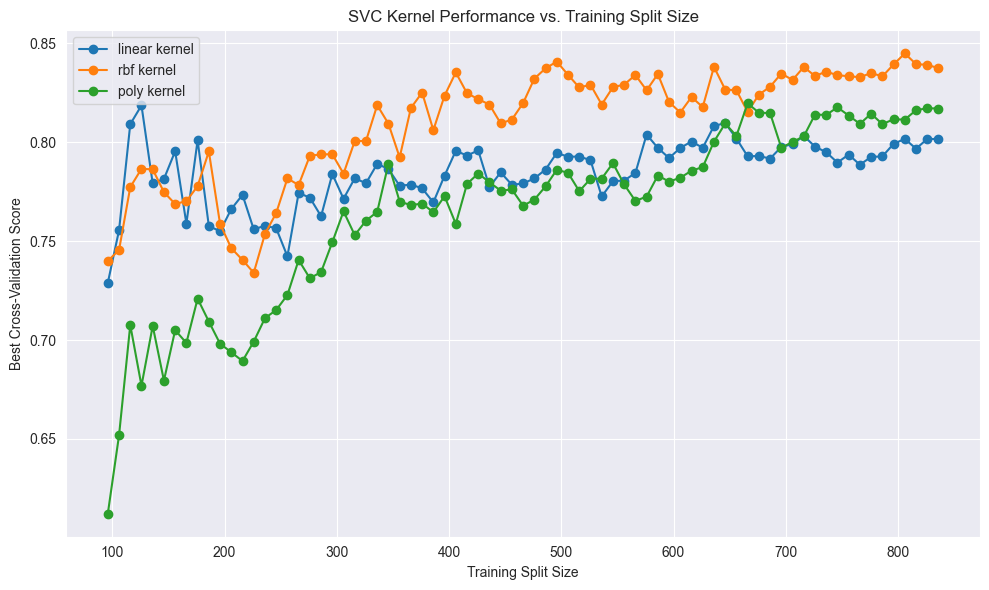

In [4]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot each kernel's scores
for i, scores in enumerate(scoreboard):
    splits = [s for s, _ in scores]
    scores_values = [score for _, score in scores]
    plt.plot(splits, scores_values, marker='o', label=f'{kernel[i]} kernel')

# Customize the plot
plt.title('SVC Kernel Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

**Feature Selection**

In [5]:
# simple linear model
from sklearn.feature_selection import RFE

svc = SVC(kernel='linear')
rfe = RFE(estimator=svc, n_features_to_select=1)

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
rfe.fit(X, Y)

selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features.tolist())

ranking_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

print("\nAll features ranked:")
for _, row in ranking_df.iterrows():
    print(f"{row['Ranking']} {row['Feature']}")

Selected features: ['RADIUS_RATIO']

All features ranked:
1 RADIUS_RATIO
2 PR.AXIS_ASPECT_RATIO
3 ELONGATEDNESS
4 HOLLOWS_RATIO
5 KURTOSIS_ABOUT_MINOR
6 MAX.LENGTH_RECTANGULARITY
7 SCALED_VARIANCE_MAJOR
8 DISTANCE_CIRCULARITY
9 SCALED_VARIANCE_MINOR
10 SKEWNESS_ABOUT_MAJOR
11 SCALED_RADIUS_OF_GYRATION
12 CIRCULARITY
13 COMPACTNESS
14 PR.AXIS_RECTANGULARITY
15 SCATTER_RATIO
16 MAX.LENGTH_ASPECT_RATIO
17 KURTOSIS_ABOUT_MAJOR
18 SKEWNESS_ABOUT_MINOR


In [67]:
fscoreboard_lin = [[] for _ in range(17)]

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

for numfeats in range(1, 18):
    selected_features = ranking_df['Feature'].head(numfeats).tolist()
    X_selected = scaled_df[selected_features]  # Use a separate variable to avoid overwriting

    param_grid = [{
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10, 100, 1000],
        'svc__gamma': ['scale']
    }]
    # after test runs, 'svc__gamma'=='scale' gave always better results

    for split in range(96, len(df), 10):
        X_train = X_selected.iloc[:split]
        Y_train = Y.iloc[:split].astype(str)

        best_score = 0
        best_C = None

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC())
        ])

        # 10-fold cross validation (standard)
        grid_search = GridSearchCV(pipeline, param_grid[0], cv=10, n_jobs=-1)
        grid_search.fit(X_train, Y_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_C = grid_search.best_params_['svc__C']

        fscoreboard_lin[numfeats-1].append((split, best_C, best_score))

    # Print results
    print(f"\nResults for top {numfeats} features:")
    for entry in fscoreboard_lin[numfeats-1][::10]:
        print(f"Split: {entry[0]}, C: {entry[1]}, Score: {entry[2]:.4f}")


Results for top 1 features:
Split: 96, C: 0.1, Score: 0.3856
Split: 196, C: 1, Score: 0.4032
Split: 296, C: 1000, Score: 0.4390
Split: 396, C: 100, Score: 0.4164
Split: 496, C: 100, Score: 0.4476
Split: 596, C: 10, Score: 0.4481
Split: 696, C: 10, Score: 0.4369
Split: 796, C: 10, Score: 0.4436

Results for top 2 features:
Split: 96, C: 1000, Score: 0.6133
Split: 196, C: 1000, Score: 0.5242
Split: 296, C: 100, Score: 0.5203
Split: 396, C: 1000, Score: 0.5128
Split: 496, C: 10, Score: 0.5103
Split: 596, C: 10, Score: 0.5151
Split: 696, C: 1000, Score: 0.5045
Split: 796, C: 1000, Score: 0.5151

Results for top 3 features:
Split: 96, C: 1000, Score: 0.5922
Split: 196, C: 1000, Score: 0.5350
Split: 296, C: 100, Score: 0.5337
Split: 396, C: 100, Score: 0.5151
Split: 496, C: 1000, Score: 0.5201
Split: 596, C: 1000, Score: 0.5218
Split: 696, C: 100, Score: 0.5217
Split: 796, C: 1000, Score: 0.5352

Results for top 4 features:
Split: 96, C: 1000, Score: 0.5189
Split: 196, C: 1000, Score: 0.514

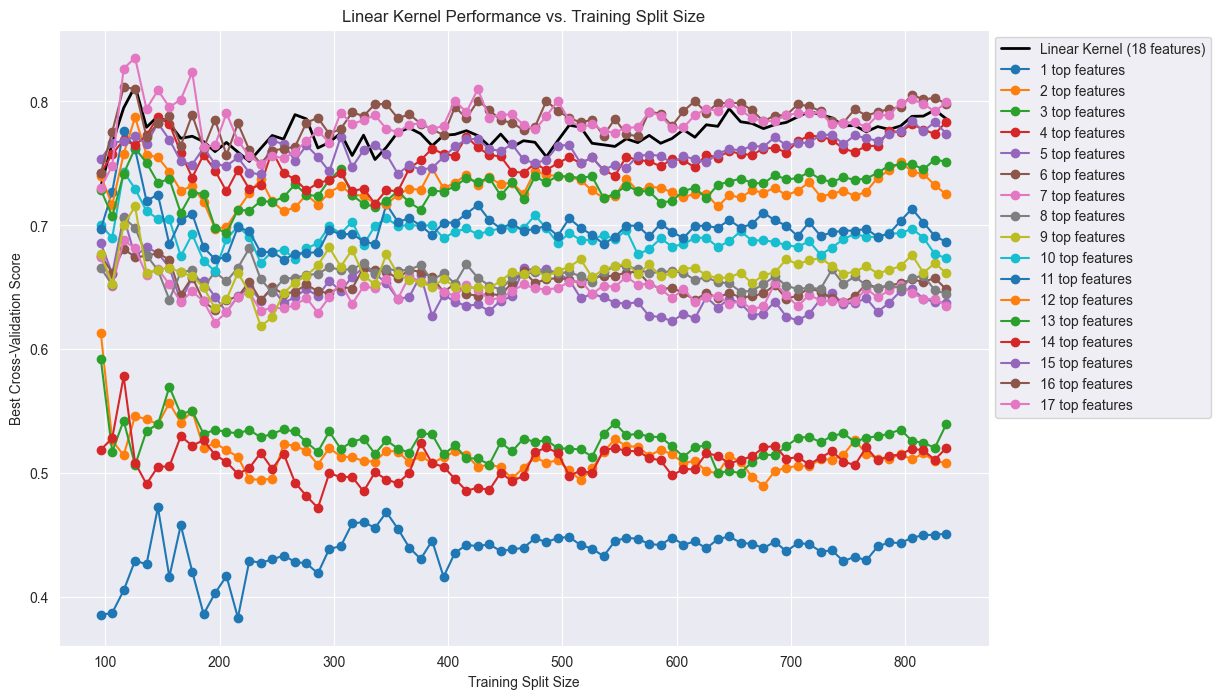

In [68]:
# Plot the original 18-feature linear kernel
plt.figure(figsize=(12, 8))  # Set figure size first

splits_orig = [s for s, score in scoreboard[0]]
scores_orig = [score for _, score in scoreboard[0]]
plt.plot(splits_orig, scores_orig, label='Linear Kernel (18 features)', color='black', linewidth=2)

# Plot each feature selection run (Top 1 to Top 17 features)
for i, scores in enumerate(fscoreboard_lin):
    splits = [s[0] for s in scores]         # split
    scores_values = [s[2] for s in scores]  # score
    plt.plot(splits, scores_values, marker='o', label=f'{i+1} top features')

plt.title('Linear Kernel Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Show the plot
plt.show()

<Figure size 800x500 with 0 Axes>

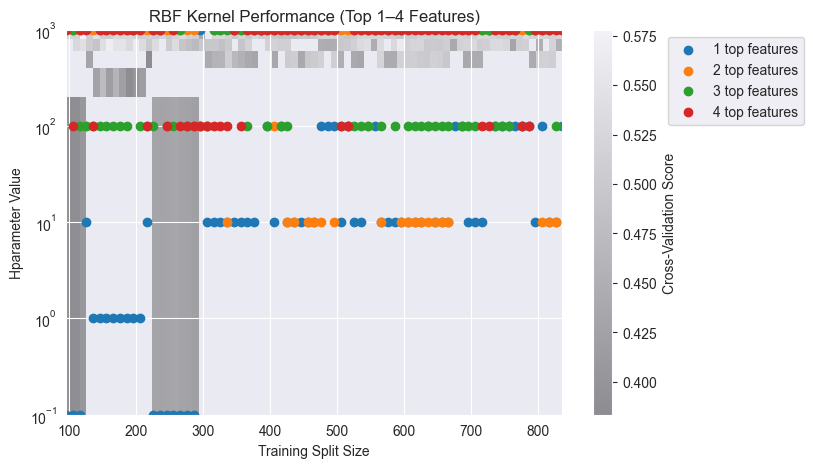

<Figure size 800x500 with 0 Axes>

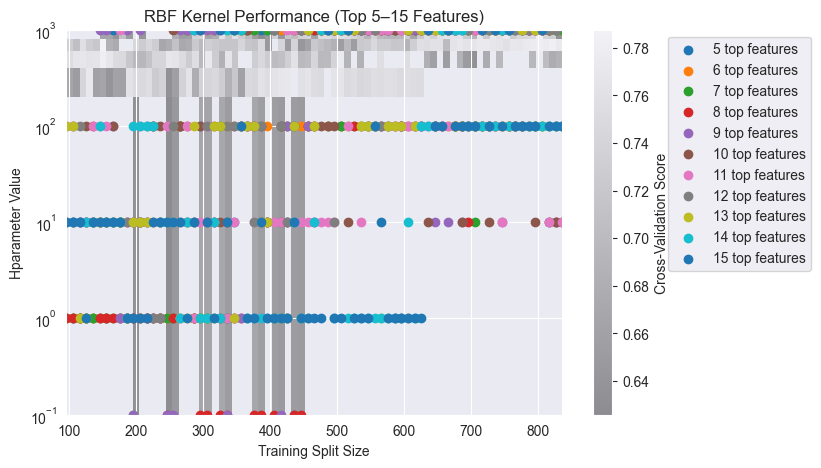

<Figure size 800x500 with 0 Axes>

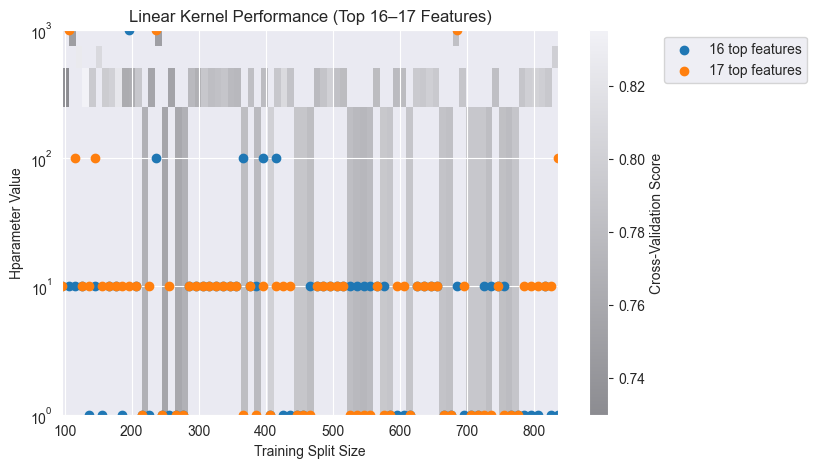

In [166]:
plt.figure(figsize=(8, 5))

flat_entries = [entry for scores in fscoreboard_lin[:4] for entry in scores]
splits = sorted(set(int(entry[0]) for entry in flat_entries))
C_vals = sorted(set(float(entry[1]) for entry in flat_entries))

score_matrix = np.full((len(C_vals), len(splits)), np.nan)
for entry in flat_entries:
    split = int(entry[0])
    C = float(entry[1])
    score = float(entry[2])
    split_idx = splits.index(split)
    C_idx = C_vals.index(C)
    score_matrix[C_idx, split_idx] = score

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(C_vals), max(C_vals)],
           origin='lower', alpha=0.4)

for i, scores in enumerate(fscoreboard_lin[:4]):
    splits = [s[0] for s in scores]
    hparams = [s[1] for s in scores]
    plt.scatter(splits, hparams, marker='o', label=f'{i+1} top features')

plt.title('RBF Kernel Performance (Top 1–4 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Hparameter Value')
plt.yscale('log')
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()


plt.figure(figsize=(8, 5))

flat_entries = [entry for scores in fscoreboard_lin[4:15] for entry in scores]
splits = sorted(set(int(entry[0]) for entry in flat_entries))
C_vals = sorted(set(float(entry[1]) for entry in flat_entries))

score_matrix = np.full((len(C_vals), len(splits)), np.nan)
for entry in flat_entries:
    split = int(entry[0])
    C = float(entry[1])
    score = float(entry[2])
    split_idx = splits.index(split)
    C_idx = C_vals.index(C)
    score_matrix[C_idx, split_idx] = score

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(C_vals), max(C_vals)],
           origin='lower', alpha=0.4)

for i, scores in enumerate(fscoreboard_lin[4:15], start=4):
    splits = [s[0] for s in scores]
    hparams = [s[1] for s in scores]
    plt.scatter(splits, hparams, marker='o', label=f'{i+1} top features')

plt.title('RBF Kernel Performance (Top 5–15 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Hparameter Value')
plt.yscale('log')
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()

plt.figure(figsize=(8, 5))

flat_entries = [entry for scores in fscoreboard_lin[16:17] for entry in scores]
splits = sorted(set(int(entry[0]) for entry in flat_entries))
C_vals = sorted(set(float(entry[1]) for entry in flat_entries))

score_matrix = np.full((len(C_vals), len(splits)), np.nan)
for entry in flat_entries:
    split = int(entry[0])
    C = float(entry[1])
    score = float(entry[2])
    split_idx = splits.index(split)
    C_idx = C_vals.index(C)
    score_matrix[C_idx, split_idx] = score

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(C_vals), max(C_vals)],
           origin='lower', alpha=0.4)

for i, scores in enumerate(fscoreboard_lin[15:17], start=15):
    splits = [s[0] for s in scores]
    hparams = [s[1] for s in scores]
    plt.scatter(splits, hparams, marker='o', label=f'{i+1} top features')

plt.title('Linear Kernel Performance (Top 16–17 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Hparameter Value')
plt.yscale('log')
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()

In [9]:
# best performing model
from sklearn.feature_selection import SelectKBest, mutual_info_classif

svc = SVC(kernel='rbf')

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
selector = SelectKBest(score_func=mutual_info_classif, k=1)
selector.fit(X, Y)

selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())

scores = selector.scores_
ranking_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': scores
}).sort_values(by='Score', ascending=False)

for _, row in ranking_df.iterrows():
    print(f"{row['Feature']} : score {row['Score']:.4f}")

Selected features: ['SCALED_VARIANCE_MINOR']
SCALED_VARIANCE_MINOR : score 0.4214
SCATTER_RATIO : score 0.3907
ELONGATEDNESS : score 0.3761
SCALED_VARIANCE_MAJOR : score 0.3727
DISTANCE_CIRCULARITY : score 0.3023
PR.AXIS_RECTANGULARITY : score 0.2983
RADIUS_RATIO : score 0.2200
MAX.LENGTH_ASPECT_RATIO : score 0.1830
SCALED_RADIUS_OF_GYRATION : score 0.1820
MAX.LENGTH_RECTANGULARITY : score 0.1804
CIRCULARITY : score 0.1701
COMPACTNESS : score 0.1641
KURTOSIS_ABOUT_MINOR : score 0.1316
SKEWNESS_ABOUT_MAJOR : score 0.1181
HOLLOWS_RATIO : score 0.1174
PR.AXIS_ASPECT_RATIO : score 0.0900
SKEWNESS_ABOUT_MINOR : score 0.0721
KURTOSIS_ABOUT_MAJOR : score 0.0538


In [70]:
fscoreboard_rbf = [[] for _ in range(17)]

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

for numfeats in range(1, 18):
    selected_features = ranking_df['Feature'].head(numfeats).tolist()
    X_selected = scaled_df[selected_features]  # Use a separate variable to avoid overwriting

    param_grid = [{
        'svc__kernel': ['rbf'],
        #Note2self, well performing models did not need penanlty > 1000
        'svc__C': [0.1, 1, 10, 100, 1000],
        'svc__gamma': ['scale']
    }]

    for split in range(96, len(df), 10):
        X_train = X_selected.iloc[:split]
        Y_train = Y.iloc[:split].astype(str)

        best_score = 0
        best_cv = None
        best_C = None

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC())
        ])

        grid_search = GridSearchCV(pipeline, param_grid[0], cv=10, n_jobs=-1)
        grid_search.fit(X_train, Y_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_C = grid_search.best_params_['svc__C']

        fscoreboard_rbf[numfeats-1].append((split, best_C, best_score))

    # Print results
    print(f"\nResults for top {numfeats} features:")
    for entry in fscoreboard_rbf[numfeats-1][::10]:
        print(f"Split: {entry[0]}, C: {entry[1]}, Score: {entry[2]:.4f}")


Results for top 1 features:
Split: 96, C: 1000, Score: 0.5078
Split: 196, C: 100, Score: 0.5042
Split: 296, C: 1000, Score: 0.5341
Split: 396, C: 1000, Score: 0.5230
Split: 496, C: 1000, Score: 0.5021
Split: 596, C: 1000, Score: 0.5101
Split: 696, C: 1000, Score: 0.5045
Split: 796, C: 1000, Score: 0.5428

Results for top 2 features:
Split: 96, C: 1000, Score: 0.6011
Split: 196, C: 100, Score: 0.5658
Split: 296, C: 1000, Score: 0.6282
Split: 396, C: 1000, Score: 0.6293
Split: 496, C: 1000, Score: 0.6313
Split: 596, C: 1000, Score: 0.6394
Split: 696, C: 1000, Score: 0.6411
Split: 796, C: 1000, Score: 0.6458

Results for top 3 features:
Split: 96, C: 1000, Score: 0.6244
Split: 196, C: 100, Score: 0.5713
Split: 296, C: 1000, Score: 0.6118
Split: 396, C: 1000, Score: 0.6442
Split: 496, C: 1000, Score: 0.6353
Split: 596, C: 1000, Score: 0.6561
Split: 696, C: 1000, Score: 0.6295
Split: 796, C: 1000, Score: 0.6307

Results for top 4 features:
Split: 96, C: 1000, Score: 0.5500
Split: 196, C: 1

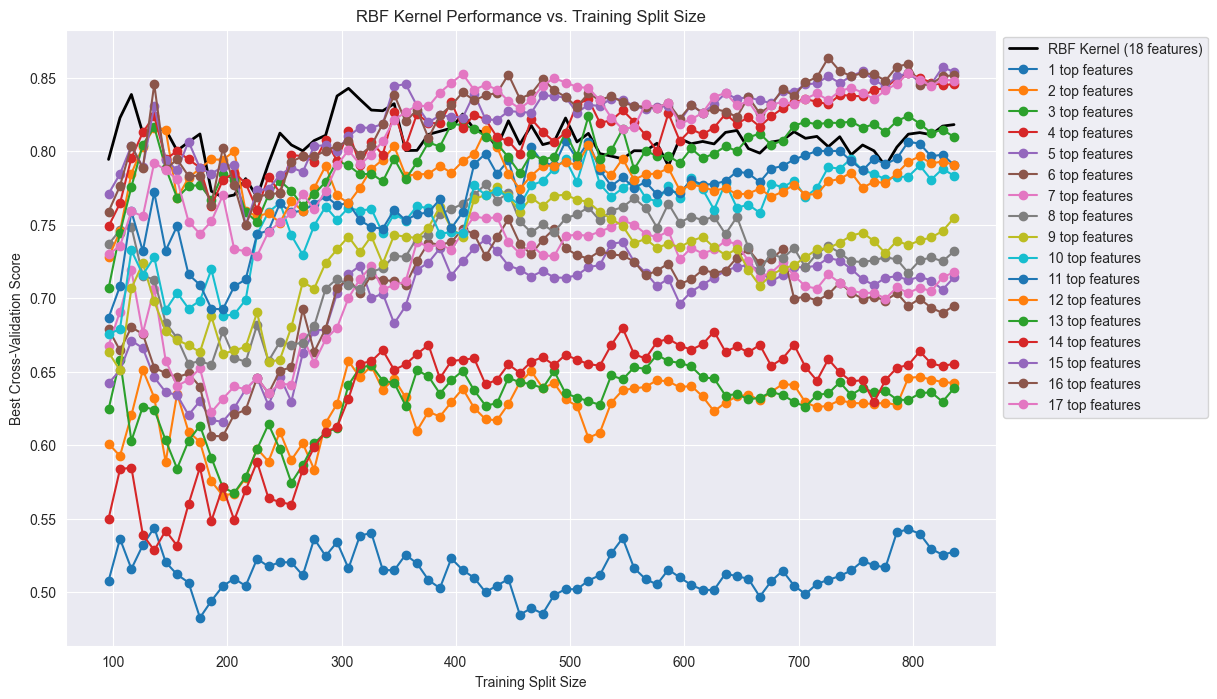

In [71]:
# Plot the original 18-feature linear kernel
plt.figure(figsize=(12, 8))  # Set figure size first

splits_orig = [s for s, score in scoreboard[1]]
scores_orig = [score for _, score in scoreboard[1]]
plt.plot(splits_orig, scores_orig, label='RBF Kernel (18 features)', color='black', linewidth=2)

# Plot each feature selection run (Top 1 to Top 17 features)
for i, scores in enumerate(fscoreboard_rbf):
    splits = [s[0] for s in scores]         # split
    scores_values = [s[2] for s in scores]  # score
    plt.plot(splits, scores_values, marker='o', label=f'{i+1} top features')

plt.title('RBF Kernel Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Show the plot
plt.show()

<Figure size 800x500 with 0 Axes>

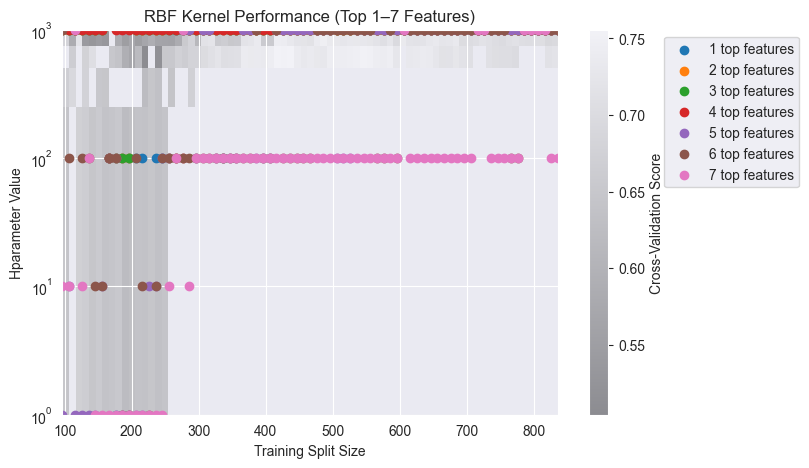

<Figure size 800x500 with 0 Axes>

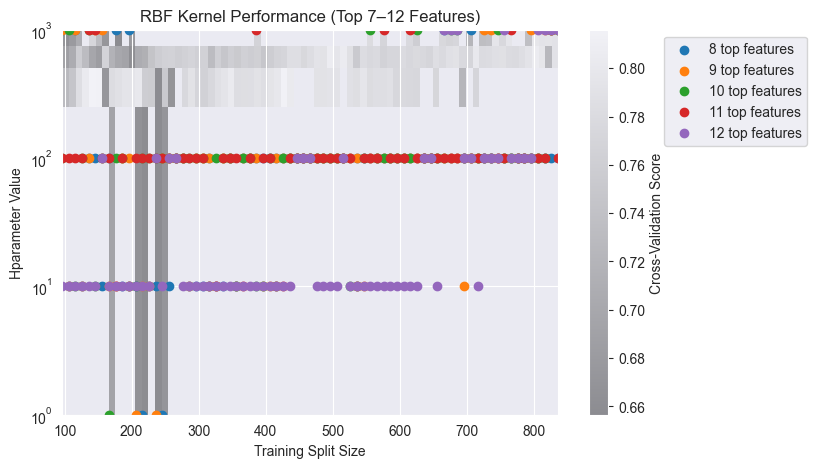

<Figure size 800x500 with 0 Axes>

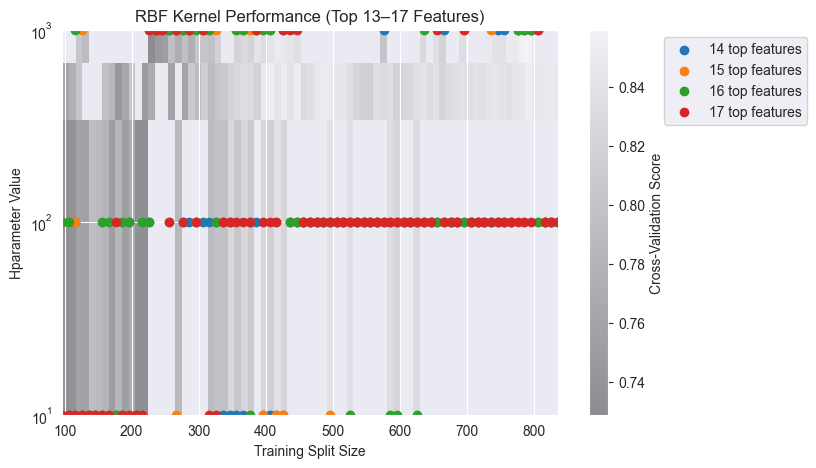

In [163]:
plt.figure(figsize=(8, 5))

flat_entries = [entry for scores in fscoreboard_rbf[:7] for entry in scores]
splits = sorted(set(int(entry[0]) for entry in flat_entries))
C_vals = sorted(set(float(entry[1]) for entry in flat_entries))

score_matrix = np.full((len(C_vals), len(splits)), np.nan)
for entry in flat_entries:
    split = int(entry[0])
    C = float(entry[1])
    score = float(entry[2])
    split_idx = splits.index(split)
    C_idx = C_vals.index(C)
    score_matrix[C_idx, split_idx] = score

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(C_vals), max(C_vals)],
           origin='lower', alpha=0.4)

for i, scores in enumerate(fscoreboard_rbf[:7]):
    splits = [s[0] for s in scores]
    hparams = [s[1] for s in scores]
    plt.scatter(splits, hparams, marker='o', label=f'{i+1} top features')

plt.title('RBF Kernel Performance (Top 1–7 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Hparameter Value')
plt.yscale('log')
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()


plt.figure(figsize=(8, 5))

flat_entries = [entry for scores in fscoreboard_rbf[7:12] for entry in scores]
splits = sorted(set(int(entry[0]) for entry in flat_entries))
C_vals = sorted(set(float(entry[1]) for entry in flat_entries))

score_matrix = np.full((len(C_vals), len(splits)), np.nan)
for entry in flat_entries:
    split = int(entry[0])
    C = float(entry[1])
    score = float(entry[2])
    split_idx = splits.index(split)
    C_idx = C_vals.index(C)
    score_matrix[C_idx, split_idx] = score

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(C_vals), max(C_vals)],
           origin='lower', alpha=0.4)

for i, scores in enumerate(fscoreboard_rbf[7:12], start=7):
    splits = [s[0] for s in scores]
    hparams = [s[1] for s in scores]
    plt.scatter(splits, hparams, marker='o', label=f'{i+1} top features')

plt.title('RBF Kernel Performance (Top 7–12 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Hparameter Value')
plt.yscale('log')
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()

plt.figure(figsize=(8, 5))

flat_entries = [entry for scores in fscoreboard_rbf[13:17] for entry in scores]
splits = sorted(set(int(entry[0]) for entry in flat_entries))
C_vals = sorted(set(float(entry[1]) for entry in flat_entries))

score_matrix = np.full((len(C_vals), len(splits)), np.nan)
for entry in flat_entries:
    split = int(entry[0])
    C = float(entry[1])
    score = float(entry[2])
    split_idx = splits.index(split)
    C_idx = C_vals.index(C)
    score_matrix[C_idx, split_idx] = score

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(C_vals), max(C_vals)],
           origin='lower', alpha=0.4)

for i, scores in enumerate(fscoreboard_rbf[13:17], start=13):
    splits = [s[0] for s in scores]
    hparams = [s[1] for s in scores]
    plt.scatter(splits, hparams, marker='o', label=f'{i+1} top features')

plt.title('RBF Kernel Performance (Top 13–17 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Hparameter Value')
plt.yscale('log')
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()

**PCA**

In [184]:
from sklearn.decomposition import PCA

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

V_list = [0.95, 0.97, 0.98, 0.99, 0.995, 0.997]
pca_scoreboard = [[[], [], []] for _ in V_list]  # 5 PCA levels × 3 kernels

for v_index, V in enumerate(V_list):
    # Option A: Keep enough components to explain 95% of variance
    pca = PCA(n_components=V)
    X_pca = pca.fit_transform(X)

    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    # Convert to DataFrame and preserve original index
    X_pca_df = pd.DataFrame(X_pca, columns=pca_columns, index=X.index)

# Option B: Choose a fixed number of components
# pca = PCA(n_components=10)
# X_pca = pca.fit_transform(X_scaled)

    param_grid = [
        {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10, 100, 1000]},
        {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': ['scale']},
        {'svc__kernel': ['poly'], 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': ['scale'], 'svc__degree': [2, 3, 4]}
    ]

    for split in range(96, len(df), 10):

        X_train = X_pca_df.iloc[:split]
        Y_train = Y.iloc[:split].astype(str)

        for i, param in enumerate(param_grid):
            best_score = 0

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('svc', SVC())
            ])

            grid_search = GridSearchCV(pipeline, param, cv=10, n_jobs=-1)
            grid_search.fit(X_train, Y_train)

            if grid_search.best_score_ > best_score:
                best_score = grid_search.best_score_

            # Record (split, best_score) for this kernel
            pca_scoreboard[v_index][i].append({
                'split': split,
                'score': best_score,
                'C': grid_search.best_params_.get('svc__C'),
                'gamma': grid_search.best_params_.get('svc__gamma'),
                'degree': grid_search.best_params_.get('svc__degree'),
                'n_components': pca.n_components_,
                'variance_threshold': V
            })

    # Print results
    print(f"\nPCA Variance: {V}")
    print("Number of components used:", pca.n_components_)

    kernel = ['linear', 'rbf', 'poly']
    for i, scores in enumerate(pca_scoreboard[v_index]):
        print(f"\nKernel: {kernel[i]}")
        for entry in scores[::10]:  # every 10th split
            split = entry['split']
            score = entry['score']
            C = entry['C']
            n_components = entry['n_components']
            print(f"Split: {split}, Score: {score:.4f}, C: {C}")


PCA Variance: 0.95
Number of components used: 7

Kernel: linear
Split: 96, Score: 0.6167, C: 1
Split: 196, Score: 0.6076, C: 100
Split: 296, Score: 0.6761, C: 1
Split: 396, Score: 0.6669, C: 100
Split: 496, Score: 0.6514, C: 1
Split: 596, Score: 0.6510, C: 100
Split: 696, Score: 0.6494, C: 10
Split: 796, Score: 0.6620, C: 1

Kernel: rbf
Split: 96, Score: 0.6678, C: 100
Split: 196, Score: 0.6837, C: 10
Split: 296, Score: 0.7399, C: 1
Split: 396, Score: 0.7325, C: 10
Split: 496, Score: 0.7176, C: 1
Split: 596, Score: 0.7097, C: 10
Split: 696, Score: 0.7099, C: 1
Split: 796, Score: 0.7388, C: 10

Kernel: poly
Split: 96, Score: 0.6178, C: 10
Split: 196, Score: 0.6166, C: 1
Split: 296, Score: 0.7031, C: 1
Split: 396, Score: 0.6822, C: 10
Split: 496, Score: 0.6835, C: 100
Split: 596, Score: 0.6846, C: 10
Split: 696, Score: 0.6826, C: 100
Split: 796, Score: 0.7200, C: 10

PCA Variance: 0.97
Number of components used: 8

Kernel: linear
Split: 96, Score: 0.6578, C: 1
Split: 196, Score: 0.6582,

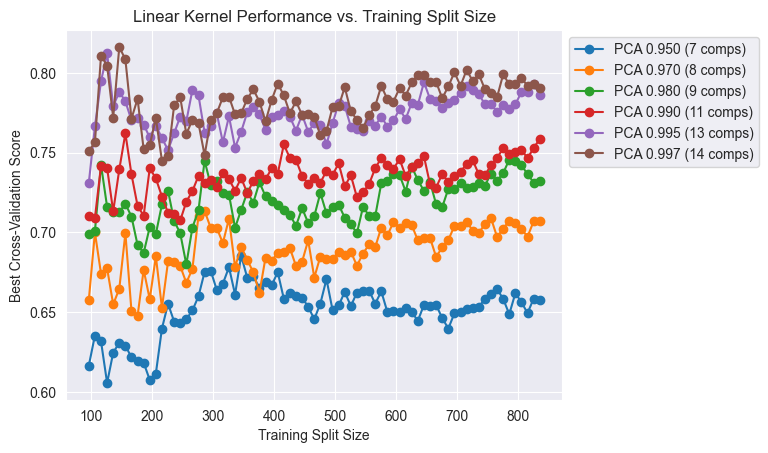

In [187]:
plt.figure(figsize=(12, 8))

# Plot original 18-feature RBF kernel last with bold styling
splits_orig = [s for s, score in scoreboard[0]]
scores_orig = [score for _, score in scoreboard[0]]
plt.plot(
    splits_orig, scores_orig,
    label='Linear Kernel (18 features)',
    color='black', linewidth=1, marker='x', markersize=4, zorder=10
)

# Plot each PCA-reduced Linear kernel run
for i, V in enumerate(V_list):
    scores = pca_scoreboard[i][0]  # [0] = linear kernel
    splits = [entry['split'] for entry in scores]
    score_values = [entry['score'] for entry in scores]
    n_components = scores[0]['n_components']
    plt.plot(splits, score_values, marker='o', label=f'PCA {V:.3f} ({scores[0]["n_components"]} comps)')

plt.title('Linear Kernel Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

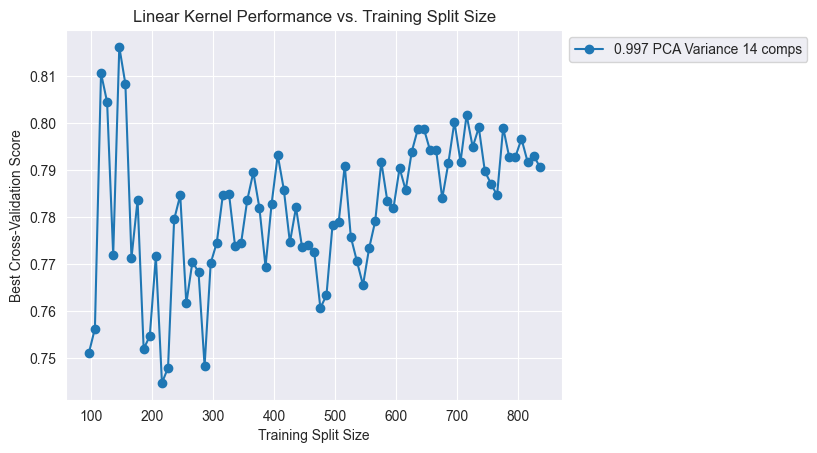

In [196]:
plt.figure(figsize=(12, 8))

# Plot original 18-feature Linear kernel last with bold styling
splits_orig = [s for s, score in scoreboard[0]]
scores_orig = [score for _, score in scoreboard[0]]
plt.plot(
    splits_orig, scores_orig,
    label='Linear Kernel (18 features)',
    color='black', linewidth=1, marker='x', markersize=4, zorder=10
)

scores = fscoreboard_lin[13]  # 14th top features
splits = [s[0] for s in scores]         # split
scores_values = [s[2] for s in scores]  # score
plt.plot(splits, scores_values, marker='o', label='Top 14 Features')
splits_pca = [entry['split'] for entry in pca_scoreboard[5][0]]
scores_pca = [entry['score'] for entry in pca_scoreboard[5][0]]
n_components = [entry['n_components'] for entry in pca_scoreboard[5][0]]
plt.plot(splits_pca, scores_pca, marker='o', label=f'0.997 PCA Variance {n_components[0]} comps')

plt.title('Linear Kernel Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

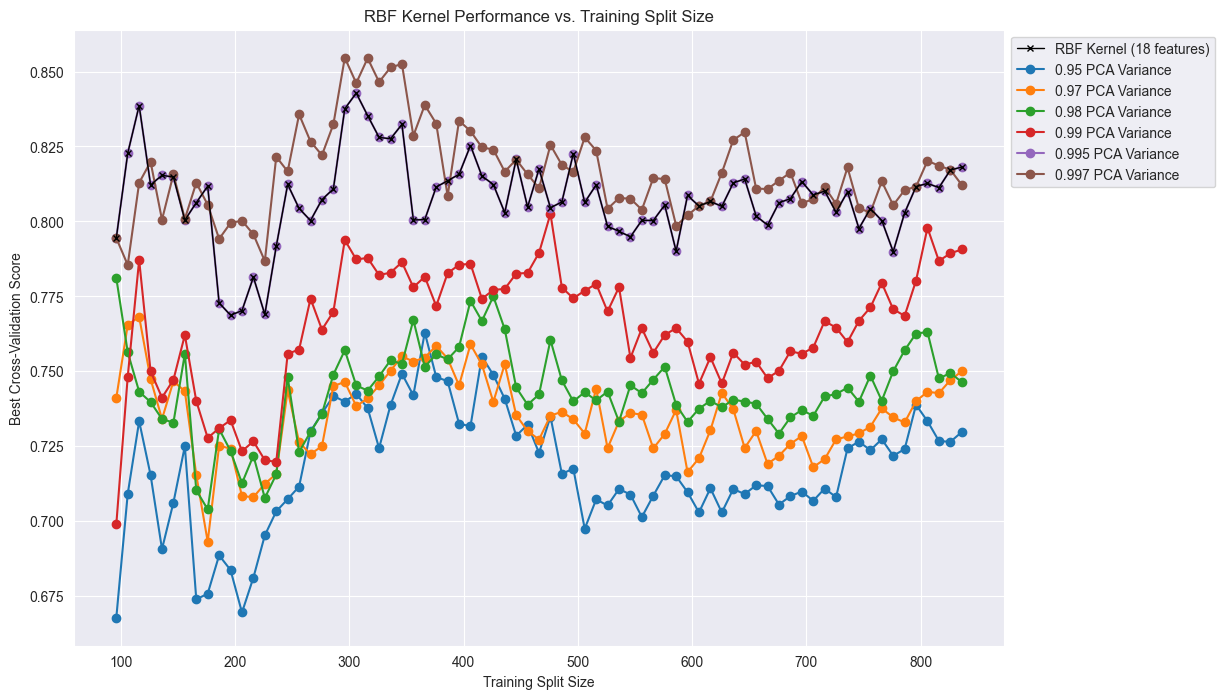

In [74]:
plt.figure(figsize=(12, 8))

# Plot original 18-feature RBF kernel
splits_orig = [s for s, score in scoreboard[1]]
scores_orig = [score for _, score in scoreboard[1]]
plt.plot(
    splits_orig, scores_orig,
    label='RBF Kernel (18 features)',
    color='black', linewidth=1, marker='x', markersize=4, zorder=10
)

# Plot each PCA-reduced RBF kernel run
for i, V in enumerate(V_list):
    scores = pca_scoreboard[i][1]
    splits = [s for s, _ in scores]
    scores_values = [score for _, score in scores]
    plt.plot(splits, scores_values, marker='o', label=f'{V} PCA Variance')

plt.title('RBF Kernel Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

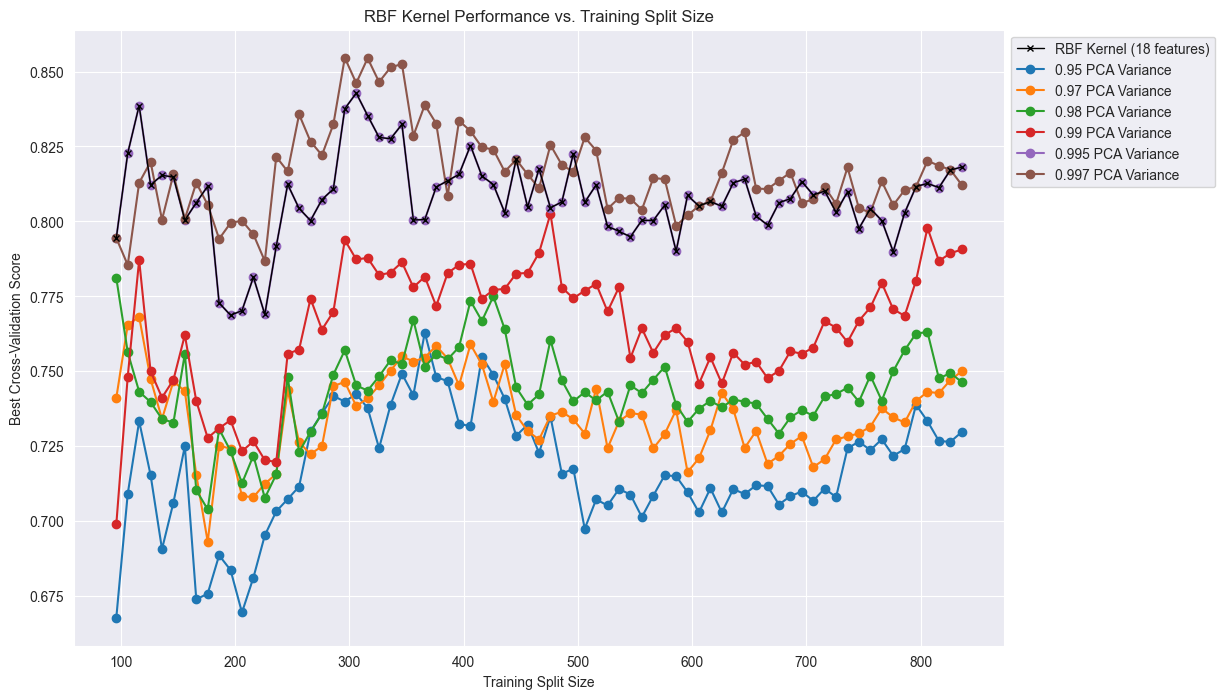

In [75]:
plt.figure(figsize=(12, 8))

# Plot original 18-feature RBF kernel last with bold styling
splits_orig = [s for s, score in scoreboard[1]]
scores_orig = [score for _, score in scoreboard[1]]
plt.plot(
    splits_orig, scores_orig,
    label='RBF Kernel (18 features)',
    color='black', linewidth=1, marker='x', markersize=4, zorder=10
)

# Plot each PCA-reduced RBF kernel run
for i, V in enumerate(V_list):
    scores = pca_scoreboard[i][1]  # RBF kernel scores for PCA level i
    splits = [s for s, _ in scores]
    scores_values = [score for _, score in scores]
    plt.plot(splits, scores_values, marker='o', label=f'{V} PCA Variance')

plt.title('RBF Kernel Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

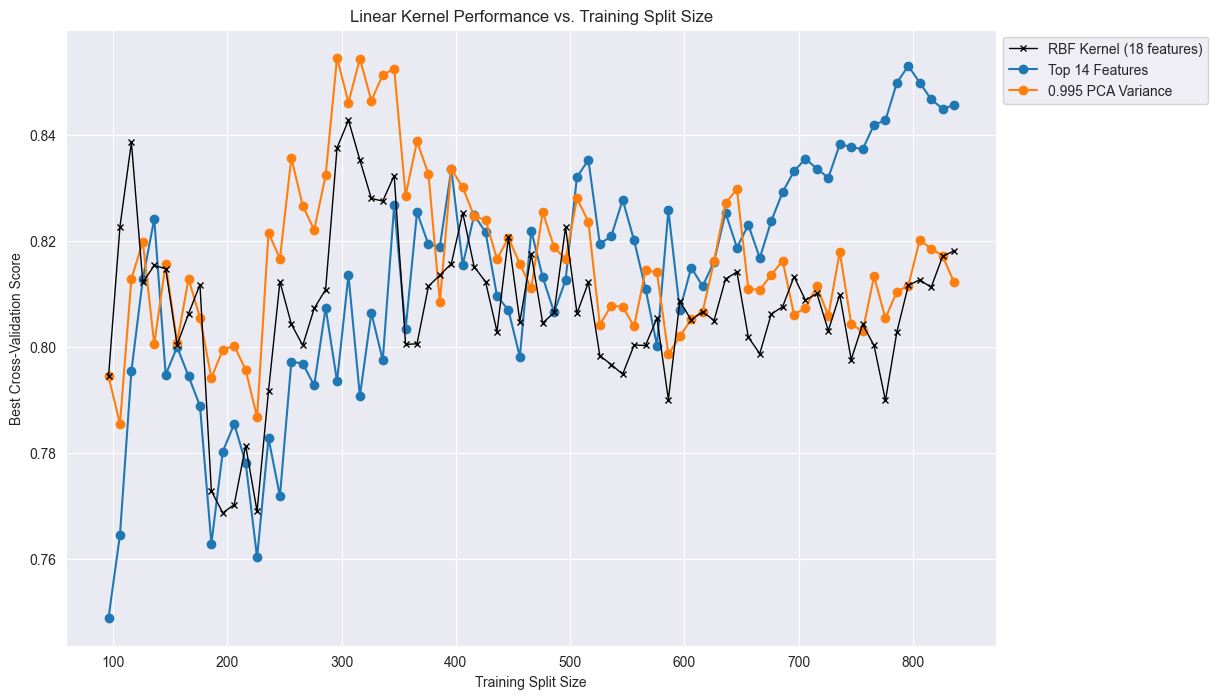

In [76]:
plt.figure(figsize=(12, 8))

# Plot original 18-feature RBF kernel last with bold styling
splits_orig = [s for s, score in scoreboard[1]]
scores_orig = [score for _, score in scoreboard[1]]
plt.plot(
    splits_orig, scores_orig,
    label='RBF Kernel (18 features)',
    color='black', linewidth=1, marker='x', markersize=4, zorder=10
)

scores = fscoreboard_rbf[13]  # 14th top features
splits = [s[0] for s in scores]         # split
scores_values = [s[2] for s in scores]  # score
plt.plot(splits, scores_values, marker='o', label='Top 14 Features')

splits_pca = [entry['split'] for entry in pca_scoreboard[5][1]]
scores_pca = [entry['score'] for entry in pca_scoreboard[5][1]]
n_components = [entry['n_components'] for entry in pca_scoreboard[5][1]]
plt.plot(splits_pca, scores_pca, marker='o', label=f'0.997 PCA Variance {n_components[0]} comps')

plt.title('Linear Kernel Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

**SVM Model Analysis**

In [213]:
def evaluate_model(best_model,method):
    num_features = best_model['num_features']
    split = best_model['split']
    C = best_model['C']

    if method == 'pca':
        X_train = X_pca_df.iloc[:split]
        X_test = X_pca_df.iloc[split:]

    else:
        selected_features = ranking_df['Feature'].head(num_features).tolist()
        X_selected = scaled_df[selected_features]
        X_train = X_selected.iloc[:split]
        X_test = X_selected.iloc[split:]

    Y_clean = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x).astype(str)
    Y_train = Y_clean.iloc[:split]
    Y_test = Y_clean.iloc[split:]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='linear', C=C))
    ])

    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)

    print(f"\n Evaluation for Linear SVM with top {num_features} features:")
    print("Accuracy:", accuracy_score(Y_test, Y_pred))
    print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
    print("Recall:", recall_score(Y_test, Y_pred, average='macro'))
    print("F1 Score:", f1_score(Y_test, Y_pred, average='macro'))
    print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))

In [214]:
best_lin = None
best_lin_pca = None
score_lin = -1
score_lin_pca = -1

for numfeats, scores in enumerate(fscoreboard_lin):
    for entry in scores:
        split = entry[0]
        C = entry[1]
        score = entry[2]

        if score > score_lin:
            score_lin = score
            best_lin = {
                'num_features': numfeats,
                'split': split,
                'C': C,
                'score': score
            }

print("\n Best Linear Model:")
for k, v in best_lin.items():
    print(f"{k}: {v}")
evaluate_model(best_lin,_)

for v_index, scores_by_kernel in enumerate(pca_scoreboard):
    scores = scores_by_kernel[0]
    for entry in scores:
        split = entry['split']
        C = entry['C']
        score = entry['score']
        n_components = entry['n_components']

        if score > score_lin_pca:
            score_lin_pca = score
            best_lin_pca = {
                'num_features': n_components,
                'split': split,
                'C': C,
                'score': score
            }

print("\n Best Linear Model:")
for k, v in best_lin_pca.items():
    print(f"{k}: {v}")
evaluate_model(best_lin_pca,'pca')


 Best Linear Model:
num_features: 16
split: 126
C: 10
score: 0.8352564102564104

 Evaluation for Linear SVM with top 16 features:
Accuracy: 0.7041666666666667
Precision: 0.730063785850941
Recall: 0.7097180300177226
F1 Score: 0.7165403671558309
Confusion Matrix:
 [[160   3  18   2]
 [ 13  95  76   1]
 [ 11  62 119   0]
 [  5   3  19 133]]

 Best Linear Model:
num_features: 14
split: 146
C: 1
score: 0.8161904761904761

 Evaluation for Linear SVM with top 14 features:
Accuracy: 0.73
Precision: 0.7445731228726152
Recall: 0.7371026881850207
F1 Score: 0.7404217801590889
Confusion Matrix:
 [[162   4  11   1]
 [  6 104  65   6]
 [  8  66 111   2]
 [  4   6  10 134]]


In [216]:
best_rbf = None
best_rbf_pca = None
score_rbf = -1
score_rbf_pca = -1

for numfeats, scores in enumerate(fscoreboard_rbf):
    for entry in scores:
        split = entry[0]
        C = entry[1]
        score = entry[2]

        if score > score_rbf:
            score_rbf = score
            best_rbf = {
                'num_features': numfeats,
                'split': split,
                'C': C,
                'score': score
            }

print("\n Best RBF Model:")
for k, v in best_rbf.items():
    print(f"{k}: {v}")
evaluate_model(best_rbf,_)

for v_index, scores_by_kernel in enumerate(pca_scoreboard):
    scores = scores_by_kernel[1]
    for entry in scores:
        split = entry['split']
        C = entry['C']
        score = entry['score']
        n_components = entry['n_components']

        if score > score_rbf_pca:
            score_rbf_pca = score
            best_rbf_pca = {
                'num_features': n_components,
                'split': split,
                'C': C,
                'score': score,
            }

print("\n Best RBF Model:")
for k, v in best_rbf_pca.items():
    print(f"{k}: {v}")
evaluate_model(best_rbf_pca,'pca')


 Best RBF Model:
num_features: 15
split: 726
C: 100
score: 0.8636225266362253

 Evaluation for Linear SVM with top 15 features:
Accuracy: 0.8583333333333333
Precision: 0.8570767256745959
Recall: 0.8575013147021261
F1 Score: 0.8557088574621821
Confusion Matrix:
 [[29  0  1  0]
 [ 2 19  5  1]
 [ 3  4 27  0]
 [ 0  1  0 28]]

 Best RBF Model:
num_features: 14
split: 296
C: 100
score: 0.8545977011494253

 Evaluation for Linear SVM with top 14 features:
Accuracy: 0.7545454545454545
Precision: 0.7684955071036901
Recall: 0.7642776782600966
F1 Score: 0.7649510816794711
Confusion Matrix:
 [[127   4   3   0]
 [  9  95  39   5]
 [  5  51  93   1]
 [  7   5   6 100]]


**Random Forest**

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

scoreboard = []

param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
}

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

for split in range(96, len(df), 10):

    X_train = X.iloc[:split]
    Y_train = Y.iloc[:split].astype(str)

    best_score = 0
    best_estimators = None
    best_max_depth = None
    best_min_samples_split = None
    best_min_samples_leaf = None

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier())
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_estimators = grid_search.best_estimator_
        best_max_depth = grid_search.best_params_['rf__max_depth']
        best_min_samples_split = grid_search.best_params_['rf__min_samples_split']
        best_min_samples_leaf = grid_search.best_params_['rf__min_samples_leaf']

    # Record (split, best_score) for this kernel
    scoreboard.append({
        'split': split,
        'score': best_score,
        'n_estimators': grid_search.best_params_['rf__n_estimators'],
        'max_depth': grid_search.best_params_['rf__max_depth'],
        'min_samples_split': grid_search.best_params_['rf__min_samples_split'],
        'min_samples_leaf': grid_search.best_params_['rf__min_samples_leaf']
    })
for i in range(0, len(scoreboard), 10):  # every 10th index
    entry = scoreboard[i]
    print(f"Split: {entry['split']}, Score: {entry['score']:.4f}, n_estimators: {entry['n_estimators']}, max_depth: {entry['max_depth']}, min_samples_split: {entry['min_samples_split']}, min_samples_leaf: {entry['min_samples_leaf']}")

Split: 96, Score: 0.7489, n_estimators: 100, max_depth: 20, min_samples_split: 5, min_samples_leaf: 2
Split: 196, Score: 0.7384, n_estimators: 200, max_depth: None, min_samples_split: 2, min_samples_leaf: 2
Split: 296, Score: 0.7643, n_estimators: 300, max_depth: 10, min_samples_split: 2, min_samples_leaf: 1
Split: 396, Score: 0.7683, n_estimators: 200, max_depth: None, min_samples_split: 2, min_samples_leaf: 1
Split: 496, Score: 0.7762, n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 1
Split: 596, Score: 0.7668, n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 1
Split: 696, Score: 0.7657, n_estimators: 100, max_depth: 20, min_samples_split: 2, min_samples_leaf: 2
Split: 796, Score: 0.7676, n_estimators: 100, max_depth: 10, min_samples_split: 5, min_samples_leaf: 1


In [17]:
# a more extensive one
from sklearn.ensemble import RandomForestClassifier

scoreboard = []

param_grid = {
    'rf__n_estimators': [100, 200, 300, 400],
    'rf__max_depth': [None, 10, 20, 30, 40],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2],
}

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

for split in range(96, len(df), 10):

    X_train = X.iloc[:split]
    Y_train = Y.iloc[:split].astype(str)

    best_score = 0
    best_estimators = None
    best_max_depth = None
    best_min_samples_split = None
    best_min_samples_leaf = None

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier())
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_estimators = grid_search.best_estimator_
        best_max_depth = grid_search.best_params_['rf__max_depth']
        best_min_samples_split = grid_search.best_params_['rf__min_samples_split']
        best_min_samples_leaf = grid_search.best_params_['rf__min_samples_leaf']

    # Record (split, best_score) for this kernel
    scoreboard.append({
        'split': split,
        'score': best_score,
        'n_estimators': grid_search.best_params_['rf__n_estimators'],
        'max_depth': grid_search.best_params_['rf__max_depth'],
        'min_samples_split': grid_search.best_params_['rf__min_samples_split'],
        'min_samples_leaf': grid_search.best_params_['rf__min_samples_leaf']
    })

for i in range(0, len(scoreboard), 10):  # every 10th index
    entry = scoreboard[i]
    print(f"Split: {entry['split']}, Score: {entry['score']:.4f}, n_estimators: {entry['n_estimators']}, max_depth: {entry['max_depth']}, min_samples_split: {entry['min_samples_split']}, min_samples_leaf: {entry['min_samples_leaf']}")

Split: 96, Score: 0.7400, n_estimators: 100, max_depth: 10, min_samples_split: 2, min_samples_leaf: 1
Split: 196, Score: 0.7384, n_estimators: 400, max_depth: 40, min_samples_split: 2, min_samples_leaf: 1
Split: 296, Score: 0.7744, n_estimators: 100, max_depth: 20, min_samples_split: 5, min_samples_leaf: 1
Split: 396, Score: 0.7707, n_estimators: 300, max_depth: 20, min_samples_split: 5, min_samples_leaf: 1
Split: 496, Score: 0.7742, n_estimators: 300, max_depth: 10, min_samples_split: 5, min_samples_leaf: 1
Split: 596, Score: 0.7650, n_estimators: 100, max_depth: 40, min_samples_split: 2, min_samples_leaf: 1
Split: 696, Score: 0.7701, n_estimators: 400, max_depth: 40, min_samples_split: 2, min_samples_leaf: 1
Split: 796, Score: 0.7638, n_estimators: 100, max_depth: 20, min_samples_split: 10, min_samples_leaf: 1


__TEMPLATE__

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Separate features and target
X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Optional: Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate
y_pred = best_rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importance
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
print("\nTop Features:\n", importances.sort_values(ascending=False).head(10))


Confusion Matrix:
 [[44  0  0  0]
 [ 2 18 21  1]
 [ 1 15 27  1]
 [ 0  0  0 40]]

Classification Report:
               precision    recall  f1-score   support

         bus       0.94      1.00      0.97        44
        opel       0.55      0.43      0.48        42
        saab       0.56      0.61      0.59        44
         van       0.95      1.00      0.98        40

    accuracy                           0.76       170
   macro avg       0.75      0.76      0.75       170
weighted avg       0.75      0.76      0.75       170


Top Features:
 MAX.LENGTH_ASPECT_RATIO      0.131156
SCALED_VARIANCE_MINOR        0.086552
ELONGATEDNESS                0.078485
DISTANCE_CIRCULARITY         0.066840
MAX.LENGTH_RECTANGULARITY    0.065925
COMPACTNESS                  0.063529
SCATTER_RATIO                0.060442
HOLLOWS_RATIO                0.055540
SCALED_VARIANCE_MAJOR        0.054628
PR.AXIS_ASPECT_RATIO         0.053326
dtype: float64


**KNN**

In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

scoreboard = []

param_grid = {
    'knn__n_neighbors': [i for i in range(1, 6)], # no more than 5
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}
# Note2self: tried L3-18 norm and wasnt good; validation of linear dependence

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

for split in range(96, len(df), 10):

    X_train = X.iloc[:split]
    Y_train = Y.iloc[:split].astype(str)

    best_score = 0
    best_N = None
    best_w8 = None
    best_norm = None

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_N = grid_search.best_params_['knn__n_neighbors']
        best_w8 = grid_search.best_params_['knn__weights']
        best_norm = grid_search.best_params_['knn__p']

    # Record (split, best_score) for this kernel
    scoreboard.append({
        'split': split,
        'score': best_score,
        'n_neighbors': grid_search.best_params_['knn__n_neighbors'],
        'weights': grid_search.best_params_['knn__weights'],
        'norm': grid_search.best_params_['knn__p'],
    })
for i in range(0, len(scoreboard), 10):  # every 10th index
    entry = scoreboard[i]
    print(f"Split: {entry['split']}, Score: {entry['score']:.4f}, n_neighbors: {entry['n_neighbors']}, weights: {entry['weights']}, norm: {entry['norm']}")

Split: 96, Score: 0.6867, n_neighbors: 4, weights: uniform, norm: 2
Split: 196, Score: 0.7029, n_neighbors: 5, weights: uniform, norm: 1
Split: 296, Score: 0.7434, n_neighbors: 1, weights: uniform, norm: 1
Split: 396, Score: 0.7453, n_neighbors: 4, weights: distance, norm: 1
Split: 496, Score: 0.7379, n_neighbors: 4, weights: distance, norm: 1
Split: 596, Score: 0.7333, n_neighbors: 4, weights: distance, norm: 1
Split: 696, Score: 0.7315, n_neighbors: 5, weights: distance, norm: 1
Split: 796, Score: 0.7237, n_neighbors: 4, weights: distance, norm: 1


In [92]:
fscoreboard_un = [[] for _ in range(17)]

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

for numfeats in range(1, 18):
    selected_features = ranking_df['Feature'].head(numfeats).tolist()
    X_selected = scaled_df[selected_features]  # Use a separate variable to avoid overwriting

    param_grid = {
    'knn__n_neighbors': [i for i in range(1, 20)],
    'knn__weights': ['uniform'],
    'knn__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
    }

    for split in range(96, len(df), 10):
        X_train = X_selected.iloc[:split]
        Y_train = Y.iloc[:split].astype(str)

        best_score = 0
        best_N = None
        best_norm = None

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

        # 10-fold cross validation (standard)
        grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1)
        grid_search.fit(X_train, Y_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_N = grid_search.best_params_['knn__n_neighbors']
            best_norm = grid_search.best_params_['knn__p']

        fscoreboard_un[numfeats-1].append({
            'split': split,
            'score': best_score,
            'n_neighbors': grid_search.best_params_['knn__n_neighbors'],
            'norm': grid_search.best_params_['knn__p'],
        })

    # Print results
    print(f"\nResults for top {numfeats} features:")
    for entry in fscoreboard_un[numfeats-1][::10]:
        print(f"Split: {entry['split']}, Score: {entry['score']:.4f}, n_neighbors: {entry['n_neighbors']}, norm: {entry['norm']}")


Results for top 1 features:
Split: 96, Score: 0.4989, n_neighbors: 12, norm: 1
Split: 196, Score: 0.5347, n_neighbors: 12, norm: 1
Split: 296, Score: 0.5308, n_neighbors: 10, norm: 1
Split: 396, Score: 0.5432, n_neighbors: 12, norm: 1
Split: 496, Score: 0.5365, n_neighbors: 13, norm: 1
Split: 596, Score: 0.5321, n_neighbors: 18, norm: 1
Split: 696, Score: 0.5144, n_neighbors: 9, norm: 1
Split: 796, Score: 0.5278, n_neighbors: 9, norm: 1

Results for top 2 features:
Split: 96, Score: 0.5022, n_neighbors: 1, norm: 1
Split: 196, Score: 0.5450, n_neighbors: 13, norm: 1
Split: 296, Score: 0.5511, n_neighbors: 14, norm: 2
Split: 396, Score: 0.5330, n_neighbors: 9, norm: 2
Split: 496, Score: 0.5565, n_neighbors: 11, norm: 2
Split: 596, Score: 0.5740, n_neighbors: 14, norm: 2
Split: 696, Score: 0.5706, n_neighbors: 1, norm: 2
Split: 796, Score: 0.5843, n_neighbors: 1, norm: 2

Results for top 3 features:
Split: 96, Score: 0.4978, n_neighbors: 12, norm: 2
Split: 196, Score: 0.5553, n_neighbors

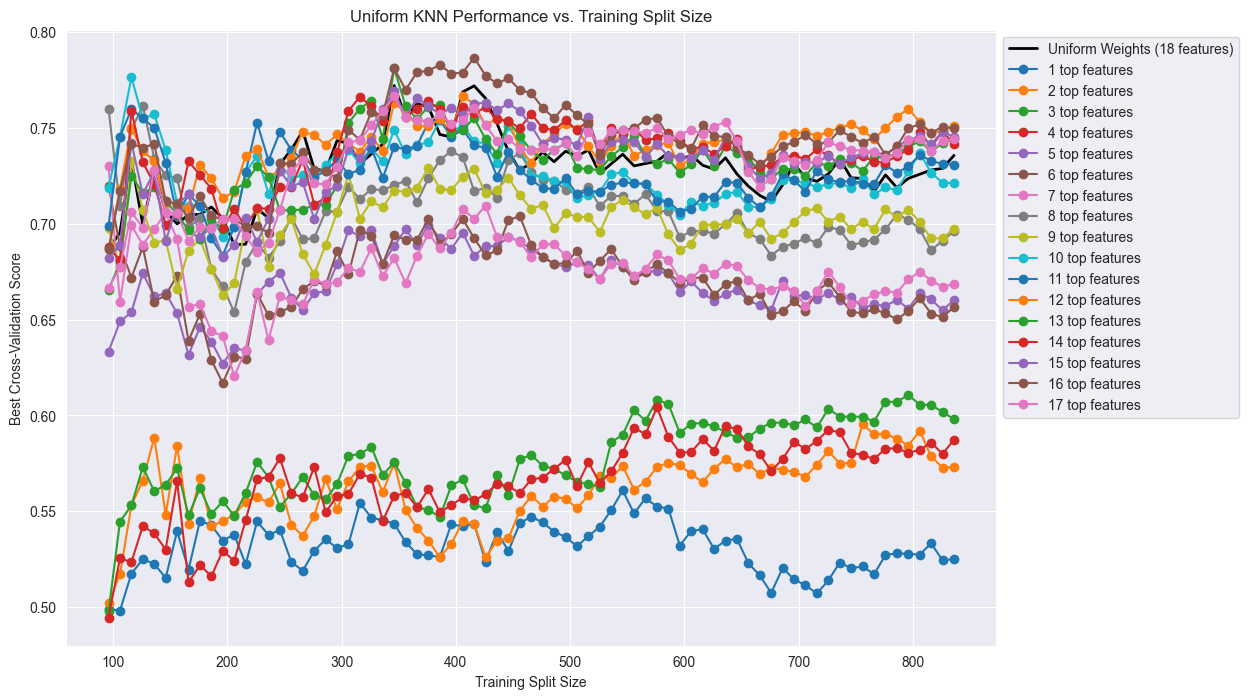

In [103]:
# Plot the original 18-feature uniform
plt.figure(figsize=(12, 8))  # Set figure size first

splits_orig = [entry['split'] for entry in scoreboard]
scores_orig = [entry['score'] for entry in scoreboard]
plt.plot(splits_orig, scores_orig, label='Uniform Weights (18 features)', color='black', linewidth=2)

# Plot each feature selection run (Top 1 to Top 17 features)
# Plot each feature selection run (Top 1 to Top 17 features)
for i, scores in enumerate(fscoreboard_un):
    splits = [s['split'] for s in scores]
    scores_values = [s['score'] for s in scores]  # score
    plt.plot(splits, scores_values, marker='o', label=f'{i+1} top features')  # score

plt.title('Uniform KNN Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

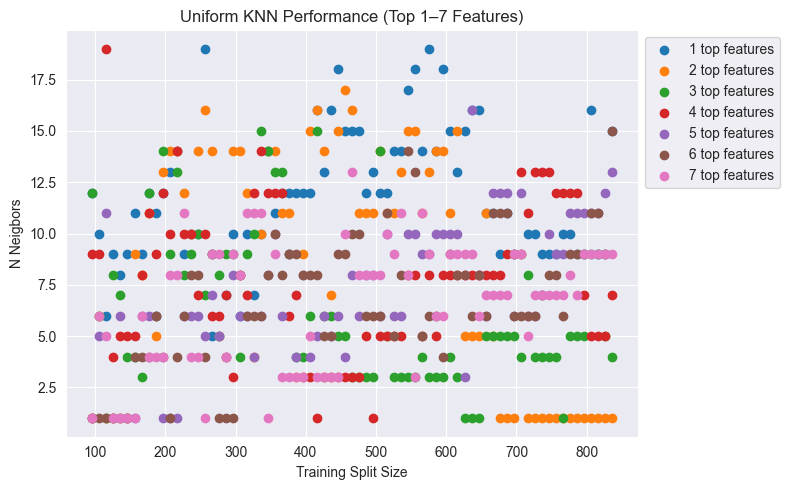

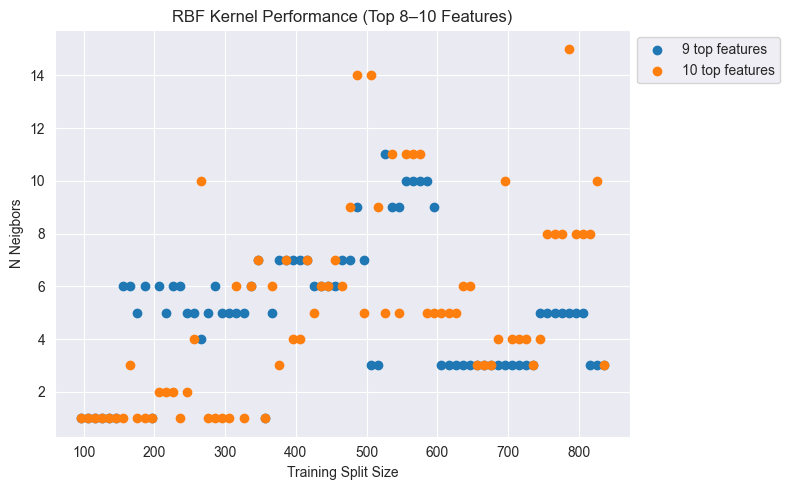

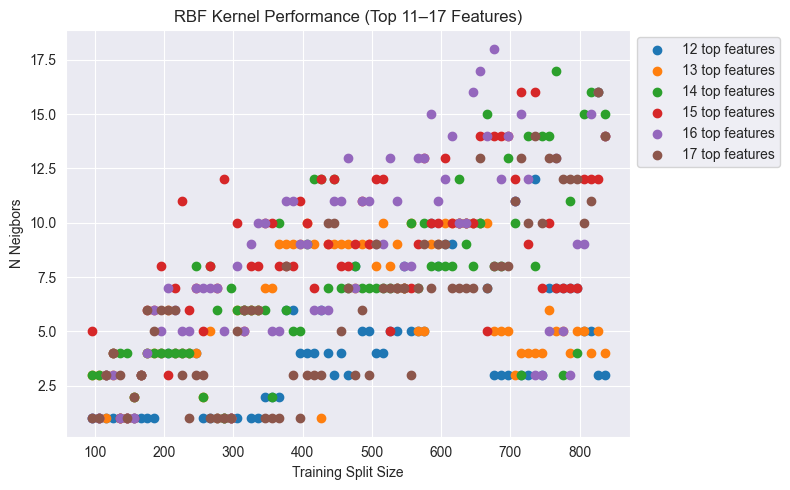

In [107]:
plt.figure(figsize=(8, 5))
for i, scores in enumerate(fscoreboard_un[:4]):
    splits = [s['split'] for s in scores]
    hparams = [s['n_neighbors'] for s in scores]
    plt.scatter(splits, hparams, marker='o', label=f'{i+1} top features')

plt.title('Uniform KNN Performance (Top 1–7 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('N Neigbors')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Second plot: indices 5 to 16 (7–10 top features)
plt.figure(figsize=(8, 5))
for i, scores in enumerate(fscoreboard_un[5:11], start=5):
    splits = [s['split'] for s in scores]
    hparams = [s['n_neighbors'] for s in scores]
    plt.scatter(splits, hparams, marker='o', label=f'{i+1} top features')

plt.title('RBF Kernel Performance (Top 8–10 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('N Neigbors')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
for i, scores in enumerate(fscoreboard_un[12:17], start=12):
    splits = [s['split'] for s in scores]
    hparams = [s['n_neighbors'] for s in scores]
    plt.scatter(splits, hparams, marker='o', label=f'{i+1} top features')

plt.title('RBF Kernel Performance (Top 11–17 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('N Neigbors')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Extract unique splits and neighbor values
splits = sorted({entry['split'] for entry in scoreboard})
neighbors = sorted({entry['n_neighbors'] for entry in scoreboard})

# Create a matrix of shape (len(neighbors), len(splits))
score_matrix = np.full((len(neighbors), len(splits)), np.nan)

# Fill the matrix
for entry in scoreboard:
    split_idx = splits.index(entry['split'])
    neigh_idx = neighbors.index(entry['n_neighbors'])
    score_matrix[neigh_idx, split_idx] = entry['score']

plt.figure(figsize=(12, 6))
plt.imshow(score_matrix, aspect='auto', cmap='viridis',
           extent=[min(splits), max(splits), min(neighbors), max(neighbors)],
           origin='lower', alpha=0.8)

plt.colorbar(label='Cross-Validation Score')
plt.title('KNN Score Heatmap: Split vs N Neighbors')
plt.xlabel('Training Split Size')
plt.ylabel('Number of Neighbors')
plt.yticks(neighbors)  # neighbors is your sorted list of integer values
plt.grid(False)
plt.show()

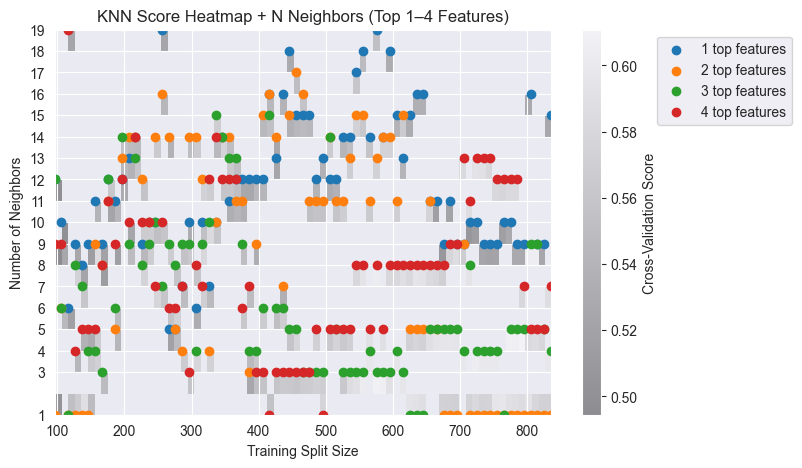

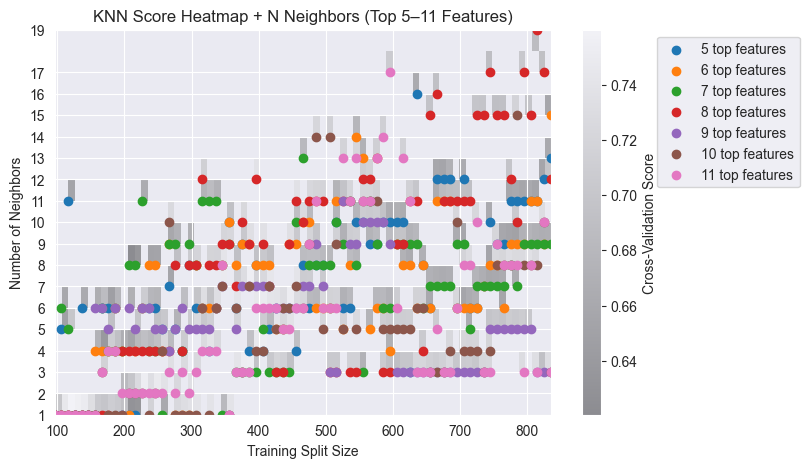

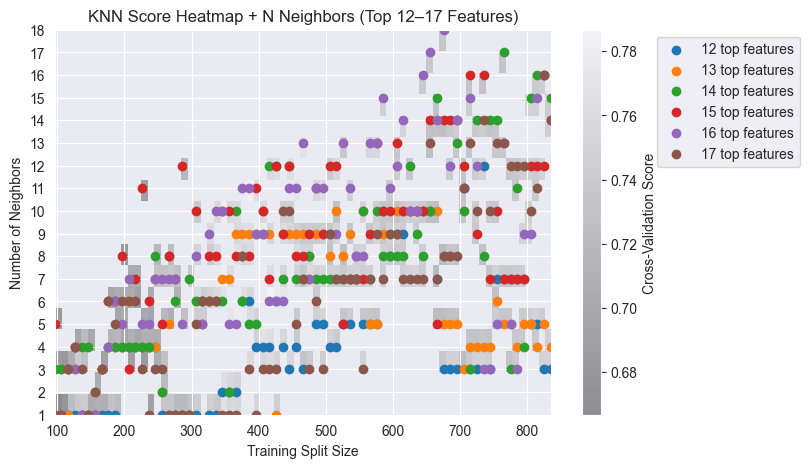

In [127]:
splits = sorted({entry['split'] for scores in fscoreboard_un[:4] for entry in scores})
neighbors = sorted({entry['n_neighbors'] for scores in fscoreboard_un[:4] for entry in scores})
score_matrix = np.full((len(neighbors), len(splits)), np.nan)

for scores in fscoreboard_un[:4]:
    for entry in scores:
        split_idx = splits.index(entry['split'])
        neigh_idx = neighbors.index(entry['n_neighbors'])
        score_matrix[neigh_idx, split_idx] = entry['score']  # overwrite or average if needed

plt.figure(figsize=(8, 5))
im =plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(neighbors), max(neighbors)],
           origin='lower', alpha=0.4)

# Scatter overlay
for i, scores in enumerate(fscoreboard_un[:4]):
    split_vals = [entry['split'] for entry in scores]
    n_vals = [entry['n_neighbors'] for entry in scores]
    plt.scatter(split_vals, n_vals, label=f'{i+1} top features', marker='o')

plt.title('KNN Score Heatmap + N Neighbors (Top 1–4 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Number of Neighbors')
plt.yticks(neighbors)  # force integer ticks
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()


splits = sorted({entry['split'] for scores in fscoreboard_un[4:11] for entry in scores})
neighbors = sorted({entry['n_neighbors'] for scores in fscoreboard_un[4:11] for entry in scores})
score_matrix = np.full((len(neighbors), len(splits)), np.nan)

for scores in fscoreboard_un[4:11]:
    for entry in scores:
        split_idx = splits.index(entry['split'])
        neigh_idx = neighbors.index(entry['n_neighbors'])
        score_matrix[neigh_idx, split_idx] = entry['score']  # overwrite or average if needed

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(neighbors), max(neighbors)],
           origin='lower', alpha=0.4)

# Scatter overlay
for i, scores in enumerate(fscoreboard_un[4:11], start=4):
    split_vals = [entry['split'] for entry in scores]
    n_vals = [entry['n_neighbors'] for entry in scores]
    plt.scatter(split_vals, n_vals, label=f'{i+1} top features', marker='o')

plt.title('KNN Score Heatmap + N Neighbors (Top 5–11 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Number of Neighbors')
plt.yticks(neighbors)  # force integer ticks
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()

splits = sorted({entry['split'] for scores in fscoreboard_un[11:17] for entry in scores})
neighbors = sorted({entry['n_neighbors'] for scores in fscoreboard_un[11:17] for entry in scores})
score_matrix = np.full((len(neighbors), len(splits)), np.nan)

for scores in fscoreboard_un[11:17]:
    for entry in scores:
        split_idx = splits.index(entry['split'])
        neigh_idx = neighbors.index(entry['n_neighbors'])
        score_matrix[neigh_idx, split_idx] = entry['score']  # overwrite or average if needed

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(neighbors), max(neighbors)],
           origin='lower', alpha=0.4)

# Scatter overlay
for i, scores in enumerate(fscoreboard_un[11:17], start=11):
    split_vals = [entry['split'] for entry in scores]
    n_vals = [entry['n_neighbors'] for entry in scores]
    plt.scatter(split_vals, n_vals, label=f'{i+1} top features', marker='o')

plt.title('KNN Score Heatmap + N Neighbors (Top 12–17 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Number of Neighbors')
plt.yticks(neighbors)  # force integer ticks
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()

In [93]:
fscoreboard_w8 = [[] for _ in range(17)]

X = scaled_df
Y = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

for numfeats in range(1, 18):
    selected_features = ranking_df['Feature'].head(numfeats).tolist()
    X_selected = scaled_df[selected_features]  # Use a separate variable to avoid overwriting

    param_grid = {
    'knn__n_neighbors': [i for i in range(1, 26)],
    'knn__weights': ['distance'],
    'knn__p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
    }

    for split in range(96, len(df), 10):
        X_train = X_selected.iloc[:split]
        Y_train = Y.iloc[:split].astype(str)

        best_score = 0
        best_N = None
        best_norm = None

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

        # 10-fold cross validation (standard)
        grid_search = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1)
        grid_search.fit(X_train, Y_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_N = grid_search.best_params_['knn__n_neighbors']
            best_norm = grid_search.best_params_['knn__p']

        fscoreboard_w8[numfeats-1].append({
            'split': split,
            'score': best_score,
            'n_neighbors': grid_search.best_params_['knn__n_neighbors'],
            'norm': grid_search.best_params_['knn__p'],
        })

    # Print results
    print(f"\nResults for top {numfeats} features:")
    for entry in fscoreboard_w8[numfeats-1][::10]:
        print(f"Split: {entry['split']}, Score: {entry['score']:.4f}, n_neighbors: {entry['n_neighbors']}, norm: {entry['norm']}")


Results for top 1 features:
Split: 96, Score: 0.4889, n_neighbors: 3, norm: 1
Split: 196, Score: 0.4847, n_neighbors: 16, norm: 1
Split: 296, Score: 0.5136, n_neighbors: 17, norm: 1
Split: 396, Score: 0.4798, n_neighbors: 8, norm: 1
Split: 496, Score: 0.4778, n_neighbors: 18, norm: 1
Split: 596, Score: 0.4884, n_neighbors: 11, norm: 1
Split: 696, Score: 0.4512, n_neighbors: 10, norm: 1
Split: 796, Score: 0.4686, n_neighbors: 7, norm: 1

Results for top 2 features:
Split: 96, Score: 0.5300, n_neighbors: 15, norm: 2
Split: 196, Score: 0.5603, n_neighbors: 19, norm: 1
Split: 296, Score: 0.5674, n_neighbors: 18, norm: 1
Split: 396, Score: 0.5178, n_neighbors: 5, norm: 1
Split: 496, Score: 0.5444, n_neighbors: 6, norm: 2
Split: 596, Score: 0.5588, n_neighbors: 11, norm: 2
Split: 696, Score: 0.5706, n_neighbors: 1, norm: 2
Split: 796, Score: 0.5882, n_neighbors: 3, norm: 2

Results for top 3 features:
Split: 96, Score: 0.5089, n_neighbors: 16, norm: 2
Split: 196, Score: 0.5553, n_neighbors:

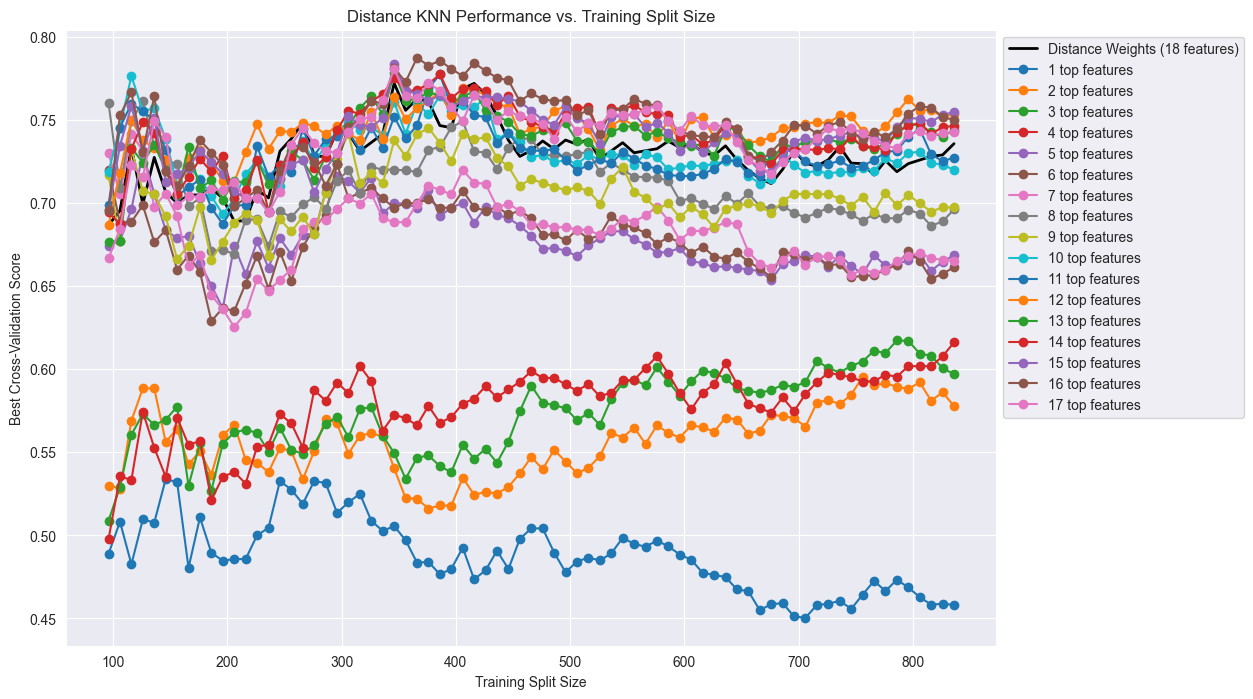

In [104]:
# Plot the original 18-feature uniform
plt.figure(figsize=(12, 8))  # Set figure size first

splits_orig = [entry['split'] for entry in scoreboard]
scores_orig = [entry['score'] for entry in scoreboard]
plt.plot(splits_orig, scores_orig, label='Distance Weights (18 features)', color='black', linewidth=2)

# Plot each feature selection run (Top 1 to Top 17 features)
# Plot each feature selection run (Top 1 to Top 17 features)
for i, scores in enumerate(fscoreboard_w8):
    splits = [s['split'] for s in scores]
    scores_values = [s['score'] for s in scores]  # score
    plt.plot(splits, scores_values, marker='o', label=f'{i+1} top features')  # score

plt.title('Distance KNN Performance vs. Training Split Size')
plt.xlabel('Training Split Size')
plt.ylabel('Best Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

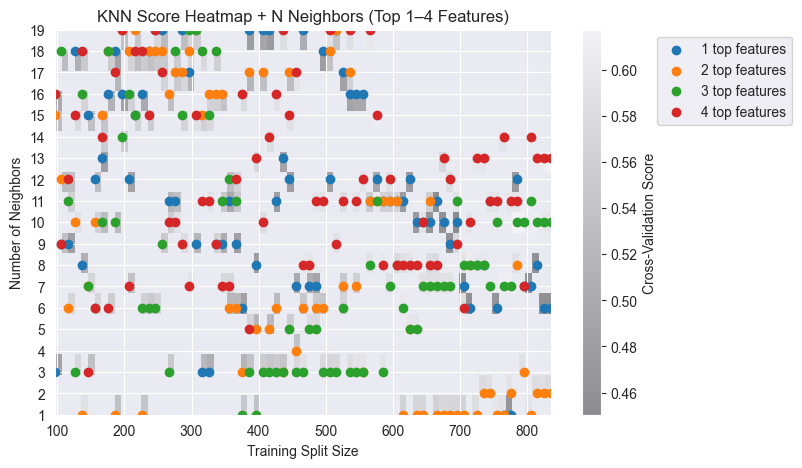

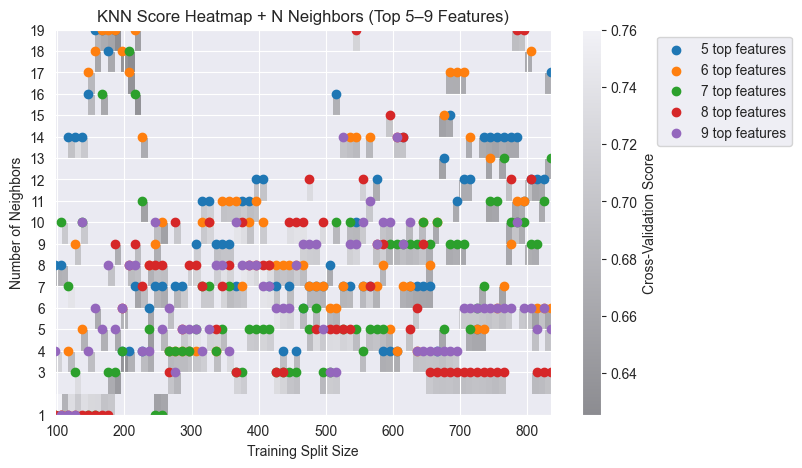

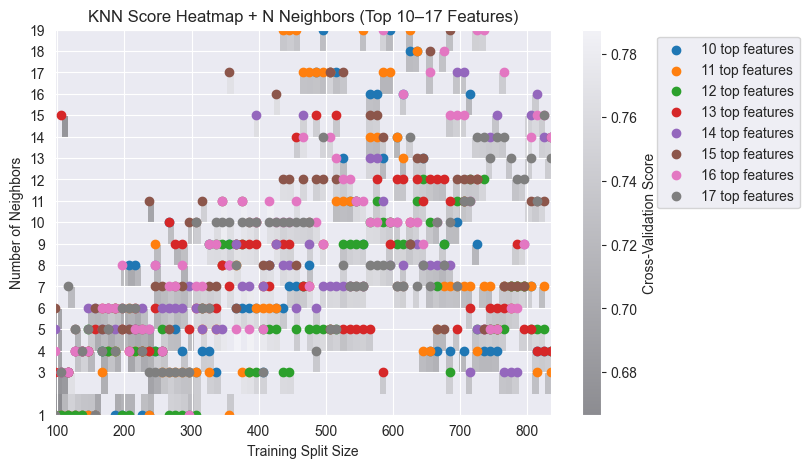

In [130]:
splits = sorted({entry['split'] for scores in fscoreboard_w8[:4] for entry in scores})
neighbors = sorted({entry['n_neighbors'] for scores in fscoreboard_w8[:4] for entry in scores})
score_matrix = np.full((len(neighbors), len(splits)), np.nan)

for scores in fscoreboard_w8[:4]:
    for entry in scores:
        split_idx = splits.index(entry['split'])
        neigh_idx = neighbors.index(entry['n_neighbors'])
        score_matrix[neigh_idx, split_idx] = entry['score']  # overwrite or average if needed

plt.figure(figsize=(8, 5))
im =plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(neighbors), max(neighbors)],
           origin='lower', alpha=0.4)

# Scatter overlay
for i, scores in enumerate(fscoreboard_w8[:4]):
    split_vals = [entry['split'] for entry in scores]
    n_vals = [entry['n_neighbors'] for entry in scores]
    plt.scatter(split_vals, n_vals, label=f'{i+1} top features', marker='o')

plt.title('KNN Score Heatmap + N Neighbors (Top 1–4 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Number of Neighbors')
plt.yticks(neighbors)  # force integer ticks
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()


splits = sorted({entry['split'] for scores in fscoreboard_w8[4:9] for entry in scores})
neighbors = sorted({entry['n_neighbors'] for scores in fscoreboard_w8[4:9] for entry in scores})
score_matrix = np.full((len(neighbors), len(splits)), np.nan)

for scores in fscoreboard_w8[4:9]:
    for entry in scores:
        split_idx = splits.index(entry['split'])
        neigh_idx = neighbors.index(entry['n_neighbors'])
        score_matrix[neigh_idx, split_idx] = entry['score']  # overwrite or average if needed

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(neighbors), max(neighbors)],
           origin='lower', alpha=0.4)

# Scatter overlay
for i, scores in enumerate(fscoreboard_w8[4:9], start=4):
    split_vals = [entry['split'] for entry in scores]
    n_vals = [entry['n_neighbors'] for entry in scores]
    plt.scatter(split_vals, n_vals, label=f'{i+1} top features', marker='o')

plt.title('KNN Score Heatmap + N Neighbors (Top 5–9 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Number of Neighbors')
plt.yticks(neighbors)  # force integer ticks
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()

splits = sorted({entry['split'] for scores in fscoreboard_w8[9:17] for entry in scores})
neighbors = sorted({entry['n_neighbors'] for scores in fscoreboard_w8[9:17] for entry in scores})
score_matrix = np.full((len(neighbors), len(splits)), np.nan)

for scores in fscoreboard_w8[9:17]:
    for entry in scores:
        split_idx = splits.index(entry['split'])
        neigh_idx = neighbors.index(entry['n_neighbors'])
        score_matrix[neigh_idx, split_idx] = entry['score']  # overwrite or average if needed

plt.figure(figsize=(8, 5))
im = plt.imshow(score_matrix, aspect='auto', cmap='gray',
           extent=[min(splits), max(splits), min(neighbors), max(neighbors)],
           origin='lower', alpha=0.4)

# Scatter overlay
for i, scores in enumerate(fscoreboard_w8[9:17], start=9):
    split_vals = [entry['split'] for entry in scores]
    n_vals = [entry['n_neighbors'] for entry in scores]
    plt.scatter(split_vals, n_vals, label=f'{i+1} top features', marker='o')

plt.title('KNN Score Heatmap + N Neighbors (Top 10–17 Features)')
plt.xlabel('Training Split Size')
plt.ylabel('Number of Neighbors')
plt.yticks(neighbors)  # force integer ticks
plt.colorbar(im, label='Cross-Validation Score')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))
plt.show()

**KNN Model Analysis**

In [143]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(best_model):
    num_features = best_model['num_features']
    split = best_model['split']
    n_neighbors = best_model['n_neighbors']
    norm = best_model['norm']

    selected_features = ranking_df['Feature'].head(num_features).tolist()
    X_selected = scaled_df[selected_features]
    Y_clean = df['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x).astype(str)

    X_train = X_selected.iloc[:split]
    Y_train = Y_clean.iloc[:split]
    X_test = X_selected.iloc[split:]
    Y_test = Y_clean.iloc[split:]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors, p=norm, weights='distance'))
    ])

    pipeline.fit(X_train, Y_train)
    Y_pred = pipeline.predict(X_test)

    print(f"\n Evaluation for L{best_model['norm']} model with top {num_features} features:")
    print("Accuracy:", accuracy_score(Y_test, Y_pred))
    print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
    print("Recall:", recall_score(Y_test, Y_pred, average='macro'))
    print("F1 Score:", f1_score(Y_test, Y_pred, average='macro'))
    print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))


In [144]:
best_l1_un = None
best_l2_un = None
score_l1_un = -1
score_l2_un = -1

for numfeats, scores in enumerate(fscoreboard_un, start=1):
    for entry in scores:
        if entry['norm'] == 1 and entry['score'] > score_l1_un:
            score_l1_un = entry['score']
            best_l1_un = {
                'num_features': numfeats,
                'split': entry['split'],
                'score': entry['score'],
                'n_neighbors': entry['n_neighbors'],
                'norm': 1
            }
        elif entry['norm'] == 2 and entry['score'] > score_l2_un:
            score_l2_un = entry['score']
            best_l2_un = {
                'num_features': numfeats,
                'split': entry['split'],
                'score': entry['score'],
                'n_neighbors': entry['n_neighbors'],
                'norm': 2
            }

print("\n Best Manhattan Model:")
for k, v in best_l1_un.items():
    print(f"{k}: {v}")
evaluate_model(best_l1_un)


print("\n Best Euclidean Model:")
for k, v in best_l2_un.items():
    print(f"{k}: {v}")
evaluate_model(best_l2_un)


 Best Manhattan Model:
num_features: 16
split: 416
score: 0.7867015098722415
n_neighbors: 6
norm: 1

 Evaluation for L1 model with top 16 features:
Accuracy: 0.713953488372093
Precision: 0.7194415800681966
Recall: 0.734024599542334
F1 Score: 0.7253766732612204
Confusion Matrix:
 [[100   0   0   0]
 [  3  50  54   8]
 [  2  44  69   5]
 [  1   3   3  88]]

 Best Euclidean Model:
num_features: 16
split: 406
score: 0.7789634146341463
n_neighbors: 9
norm: 2

 Evaluation for L2 model with top 16 features:
Accuracy: 0.7227272727272728
Precision: 0.727429830074265
Recall: 0.7415165761426522
F1 Score: 0.7335427935863159
Confusion Matrix:
 [[100   0   0   2]
 [  3  61  46   9]
 [  2  43  71   7]
 [  3   3   4  86]]


In [146]:
best_l1_w8 = None
best_l2_w8 = None
score_l1_w8 = -1
score_l2_w8 = -1

for numfeats, scores in enumerate(fscoreboard_w8, start=1):
    for entry in scores:
        if entry['norm'] == 1 and entry['score'] > score_l1_w8:
            score_l1_w8 = entry['score']
            best_l1_w8 = {
                'num_features': numfeats,
                'split': entry['split'],
                'score': entry['score'],
                'n_neighbors': entry['n_neighbors'],
                'norm': 1
            }
        elif entry['norm'] == 2 and entry['score'] > score_l2_w8:
            score_l2_w8 = entry['score']
            best_l2_w8 = {
                'num_features': numfeats,
                'split': entry['split'],
                'score': entry['score'],
                'n_neighbors': entry['n_neighbors'],
                'norm': 2
            }

print("\n Best Manhattan Model:")
for k, v in best_l1_w8.items():
    print(f"{k}: {v}")
evaluate_model(best_l1_w8)

print("\n Best Euclidean Model:")
for k, v in best_l2_w8.items():
    print(f"{k}: {v}")
evaluate_model(best_l2_w8)


 Best Manhattan Model:
num_features: 16
split: 366
score: 0.7874624624624624
n_neighbors: 5
norm: 1

 Evaluation for L1 model with top 16 features:
Accuracy: 0.7354166666666667
Precision: 0.7362217171597796
Recall: 0.7520916829194678
F1 Score: 0.7425041123041118
Confusion Matrix:
 [[113   1   1   0]
 [  5  62  54   8]
 [  3  42  77   8]
 [  0   4   1 101]]

 Best Euclidean Model:
num_features: 16
split: 416
score: 0.7842624854819975
n_neighbors: 11
norm: 2

 Evaluation for L2 model with top 16 features:
Accuracy: 0.7162790697674418
Precision: 0.7176541525314104
Recall: 0.7327641113653699
F1 Score: 0.7221995802346692
Confusion Matrix:
 [[99  0  0  1]
 [ 3 54 49  9]
 [ 2 35 73 10]
 [ 7  1  5 82]]


*SEE UNTIL HERE*

In [14]:
# Training set: first 846 rows
X_train = X.iloc[:746]
Y_train = Y.iloc[:746].astype(str)

# Validation set: next 100 rows
X_test = X.iloc[747:]
Y_test = Y.iloc[747:].astype(str)

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Basic metrics
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Precision:", precision_score(Y_test, Y_pred, average='macro'))  # Use 'binary' for binary classification
print("Recall:", recall_score(Y_test, Y_pred, average='macro'))
print("F1 Score:", f1_score(Y_test, Y_pred, average='macro'))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))

Accuracy: 0.6767676767676768
Precision: 0.6965178571428571
Recall: 0.696590909090909
F1 Score: 0.6868600217864924
Confusion Matrix:
 [[23  0  0  0]
 [ 0 14  5  3]
 [ 2 16 12  0]
 [ 0  2  4 18]]


In [15]:
from sklearn.neighbors import KNeighborsClassifier

for split in range(146, len(df), 100):
    X = scaled_df
    Y = df['Class']

    # Training set: first 846 rows
    X_train = X.iloc[:split]
    Y_train = Y.iloc[:split].astype(str)

    # Validation set: next 100 rows
    X_test = X.iloc[split+1:]
    Y_test = Y.iloc[split+1:].astype(str)

    # Initialize KNN model
    knn = KNeighborsClassifier(n_neighbors=4)

    # Fit on training data
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)

    # Basic metrics
    print("Accuracy:", accuracy_score(Y_test, Y_pred))
    print("Precision:", precision_score(Y_test, Y_pred, average='macro'))  # Use 'binary' for binary classification
    print("Recall:", recall_score(Y_test, Y_pred, average='macro'))
    print("F1 Score:", f1_score(Y_test, Y_pred, average='macro'))

    # Confusion matrix
    print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))

    print(classification_report(Y_test, Y_pred))
    print(split)


Accuracy: 0.6409155937052933
Precision: 0.6269559028839435
Recall: 0.6530364554130954
F1 Score: 0.6289634433791162
Confusion Matrix:
 [[158   8   4   8]
 [ 18  95  42  26]
 [ 24  73  63  27]
 [ 16   0   5 132]]
              precision    recall  f1-score   support

         bus       0.73      0.89      0.80       178
        opel       0.54      0.52      0.53       181
        saab       0.55      0.34      0.42       187
         van       0.68      0.86      0.76       153

    accuracy                           0.64       699
   macro avg       0.63      0.65      0.63       699
weighted avg       0.62      0.64      0.62       699

146
Accuracy: 0.672787979966611
Precision: 0.6660565616767663
Recall: 0.6870741646803803
F1 Score: 0.6698707367609806
Confusion Matrix:
 [[143   2   1   2]
 [  9  88  45  13]
 [ 14  79  60  11]
 [ 14   1   5 112]]
              precision    recall  f1-score   support

         bus       0.79      0.97      0.87       148
        opel       0.52      0.

In [16]:
correlation_matrix = numeric_df.corr()
print(correlation_matrix)

svc = SVC(kernel='linear')

from sklearn.feature_selection import RFE, mutual_info_classif

rfe = RFE(estimator=svc, n_features_to_select=5)

X_train = numeric_df
Y_train = Y_train.apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Step 3: Fit RFE on your data
rfe.fit(X_train, Y_train)

# Step 4: View selected features
print("Selected features:", rfe.support_)
print("Feature ranking:", rfe.ranking_)

                           COMPACTNESS  CIRCULARITY  DISTANCE_CIRCULARITY  \
COMPACTNESS                   1.000000     0.692869              0.792444   
CIRCULARITY                   0.692869     1.000000              0.798492   
DISTANCE_CIRCULARITY          0.792444     0.798492              1.000000   
RADIUS_RATIO                  0.691659     0.622778              0.771644   
PR.AXIS_ASPECT_RATIO          0.093222     0.149692              0.161529   
MAX.LENGTH_ASPECT_RATIO       0.148249     0.247467              0.264309   
SCATTER_RATIO                 0.813003     0.860367              0.907280   
ELONGATEDNESS                -0.788647    -0.828755             -0.912307   
PR.AXIS_RECTANGULARITY        0.813437     0.857925              0.895326   
MAX.LENGTH_RECTANGULARITY     0.676143     0.965776              0.774524   
SCALED_VARIANCE_MAJOR         0.764415     0.808496              0.864432   
SCALED_VARIANCE_MINOR         0.818632     0.852679              0.889661   

ValueError: Found input variables with inconsistent numbers of samples: [846, 746]